## Description

This implements a version of OmniFold that simplifies step2 by always starting from weight=1 and training to distinguish raw gen MC with the current pull weights from step1.  That way, the final step2 NN is a single function that gives the final gen MC event weights.

In [1]:
from __future__ import absolute_import, division, print_function

import numpy as np
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split

import tensorflow as tf

from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

from time import gmtime, strftime
import time
from stopwatch import Stopwatch, profile

import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams["text.usetex"]=False 

In [2]:
%matplotlib inline
#from IPython.core.display import display, HTML
#display(HTML("<style>.container { width:100% !important; }</style>")

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)]) #in MB

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


2023-02-03 09:00:40.767441: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-03 09:00:40.767681: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-03 09:00:40.783137: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-03 09:00:40.783394: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-03 09:00:40.783570: I tensorflow/compiler/xla/stream_executo

In [4]:
# Define default plot styles  

from matplotlib import rc
import matplotlib.font_manager

rc('font', family='serif')
rc('text', usetex=False)
rc('font', size=22)
rc('xtick', labelsize=15)
rc('ytick', labelsize=15)
rc('legend', fontsize=15)

plot_style_0 = {
    'histtype': 'step',
    'color': 'black',
    'linewidth': 2,
    'linestyle': '--',
    'density': False
}

plot_style_1 = {
    'histtype': 'step',
    'color': 'black',
    'linewidth': 2,
    'density': False
}

plot_style_2 = {'alpha': 0.5, 'density': False}

In [5]:
# Check Versions
import tensorflow as tf
print(tf.__version__)

2.11.0


# OmniFold Gaussian Toy Example

## Setup the Datasets

In [6]:
mu0 = 0
sigma0 = 1

eff = 0.1 #fraction of true but not reco
fake = 0.1 #fraction of reco but not true


##-- original value
#back = 0.1 #fraction of a background process that we would like to subtract



## Owen: learning hyperparameters

In [7]:



##-- originals

#max_epochs = 200
#batch_size_setval = 10000
#learning_rate_setval = 1e-3
#patience_setval = 10

#back = 0.1 #fraction of a background process that we would like to subtract
#background_param = (0, 1.2)  # background
#N = 10**5



#-- quick and dirty (similar to originals)

#max_epochs = 200
#batch_size_setval = 16384
#learning_rate_setval = 1e-4
#patience_setval = 20

#back = 0.1 #fraction of a background process that we would like to subtract
#background_param = (0, 1.2)  # background
#N = 10**5





##-- alt1
##-- more thorough set with more events, higher background, wider background width 
##  3 min + 50 min

#max_epochs = 200
#batch_size_setval = 1000
#learning_rate_setval = 1e-4
#patience_setval = 40

#back = 0.2 #fraction of a background process that we would like to subtract
#background_param = (0, 3)  # background
#N = 3*10**5






##-- alt2
##-- more thorough set with a lot more events, higher background, wider background width 
##   About 3 hours.

#max_epochs = 200
#batch_size_setval = 1000
#learning_rate_setval = 1e-4
#patience_setval = 40

#back = 0.2 #fraction of a background process that we would like to subtract
#background_param = (0, 3)  # background
#N = 10**6



##-- alt4
##   similar to alt2 but with a much larger batch size.
##-- more thorough set with more events, higher background, wider background width 
##  about 30 min

max_epochs = 200
batch_size_setval = 16384
learning_rate_setval = 1e-4
patience_setval = 40

back = 0.2 #fraction of a background process that we would like to subtract
background_param = (0, 3)  # background
N = 3*10**5



##-- alt5
##   similar to alt4 but with sample size of 1M.
##-- more thorough set with more events, higher background, wider background width 
##  about 30 min

#max_epochs = 200
#batch_size_setval = 16384
#learning_rate_setval = 1e-4
#patience_setval = 40

#back = 0.2 #fraction of a background process that we would like to subtract
#background_param = (0, 3)  # background
#N = 10**6




stopwatch = Stopwatch()


In [8]:
%%time

#N = 10**5


# param = (mu, sigma)
theta0_param = (mu0, sigma0)  # synthetic sample
theta_unknown_param = (0.2, 0.8)  # this is the data (the target)
#background_param = (0, 1.2)  # background
#background_param = (0, 3)  # background
epsilon = sigma0 / 2.  # Smearing width

dummyval = -10 #a value for examples that don't pass one of the measured/ideal selections

#Synthetic
theta0_G = np.random.normal(theta0_param[0], theta0_param[1],N)  # Generator-level synthetic sample
theta0_S = np.array([(x + np.random.normal(0, epsilon)) for x in theta0_G])  # Detector smearing for synthetic sample
pass_reco = np.random.binomial(1,1.-eff,len(theta0_G))
pass_truth = np.random.binomial(1,1.-fake,len(theta0_G)) # what a concise Toy MC with cuts!
theta0_S[pass_reco==0] = dummyval
theta0_G[pass_truth==0] = dummyval

theta0_background = np.random.normal(background_param[0],background_param[1], int(N*back))
theta0_S_withback = np.concatenate([theta0_S,theta0_background]) #smeared synthetic (mc_reco)+background
theta0_G_withback = np.concatenate([theta0_G,-np.ones(int(N*back))*dummyval]) #gen synthetic (mc_truth)+background

theta0 = np.stack([theta0_G, theta0_S], axis=1)
labels0 = np.zeros(len(theta0))

#Natural
theta_unknown_G = np.random.normal(theta_unknown_param[0],theta_unknown_param[1], N) # Nature, particle-level analog
theta_unknown_S = np.array([(x + np.random.normal(0, epsilon)) for x in theta_unknown_G]) # Measured Data analog
pass_reco = np.random.binomial(1,1.-eff,len(theta_unknown_G))
pass_truth = np.random.binomial(1,1.-fake,len(theta_unknown_G))
theta_unknown_S[pass_reco==0] = dummyval
theta_unknown_G[pass_truth==0] = dummyval #emulates cuts done in an analysis

theta_background = np.random.normal(background_param[0],background_param[1], int(N*back))
theta_unknown_S_withback = np.concatenate([theta_unknown_S,theta_background]) #Nature+background
theta_unknown_G_withback = np.concatenate([theta_unknown_G,-np.ones(int(N*back))*dummyval]) #Data+Background

theta_unknown = np.stack([theta_unknown_G, theta_unknown_S], axis=1)
labels_unknown = np.ones(len(theta_unknown))

CPU times: user 1.58 s, sys: 15.3 ms, total: 1.59 s
Wall time: 1.59 s


In [9]:
theta0_G

array([ 0.39166197, -1.26828102, -0.57845747, ..., -0.01504108,
       -0.91478002,  0.22333354])

In [10]:
theta0_S

array([ 0.51367515, -1.29295562, -0.7259526 , ..., -0.93032238,
       -1.14080729,  0.75900925])

In [11]:
theta0

array([[ 0.39166197,  0.51367515],
       [-1.26828102, -1.29295562],
       [-0.57845747, -0.7259526 ],
       ...,
       [-0.01504108, -0.93032238],
       [-0.91478002, -1.14080729],
       [ 0.22333354,  0.75900925]])

In [12]:
labels0

array([0., 0., 0., ..., 0., 0., 0.])

In [13]:
labels0.shape

(300000,)

In [14]:
theta0.shape

(300000, 2)

In [15]:
labels_unknown

array([1., 1., 1., ..., 1., 1., 1.])

In [16]:
labels_unknown.shape

(300000,)

/tmp/ipykernel_3902049/177983796.py:30: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


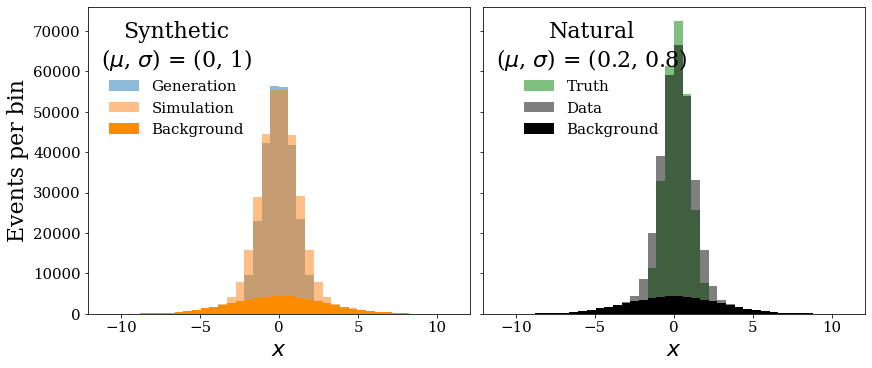

In [17]:
bins = np.linspace(-11, 11, 41)

fig, ax = plt.subplots(1,
                       2,
                       figsize=(12, 5),
                       constrained_layout=True,
                       sharey=True)

ax[0].set_xlabel(r'$x$')
ax[0].set_ylabel(r'Events per bin')
ax[0].hist(theta0_G[theta0_G!=dummyval], bins=bins, **plot_style_2, label='Generation')
ax[0].hist(theta0_S_withback[theta0_S_withback!=dummyval], bins=bins, **plot_style_2, label='Simulation')
ax[0].hist(theta0_S_withback[theta0_G_withback==-dummyval], bins=bins, color="darkorange", label='Background')
legend = ax[0].legend(
    title=r'Synthetic''\n''($\mu$, $\sigma$) = {}'.format(theta0_param),
    loc='upper left',
    frameon=False)
plt.setp(legend.get_title(), multialignment='center')

ax[1].set_xlabel(r'$x$')
ax[1].hist(theta_unknown_G[theta_unknown_G!=dummyval], bins=bins, **plot_style_2, label='Truth',color="green")
ax[1].hist(theta_unknown_S_withback[theta_unknown_S_withback!=dummyval], bins=bins, **plot_style_2, label='Data',color="black")
ax[1].hist(theta_unknown_S_withback[theta_unknown_G_withback==-dummyval], bins=bins, label='Background',color="black")
legend = ax[1].legend(
    title=r'Natural''\n''($\mu$, $\sigma$) = {}'.format(theta_unknown_param),
    loc='upper left',
    frameon=False)
plt.setp(legend.get_title(), multialignment='center')

fig.show()

## Unfold Data

In [18]:
iterations = 4

In [19]:
xvals_1 = np.concatenate((theta0_S, theta_unknown_S)) #synthetic, measured.
yvals_1 = np.concatenate((labels0, labels_unknown)) 
#QUESTION: At what point are theses mixed? Avoid [0,0,0...0,1,1...1,1,1]
#I think at test_train_split function

xvals_2 = np.concatenate((theta0_G, theta0_G)) 
#QUESTION whay 0_G twice? Because theta_unknown_G is ultimate target (particle level – nature), 
#and can't be used as an input to the training.
yvals_2 = np.concatenate((labels0, labels_unknown))

weights = np.empty(shape=(iterations, 2, len(theta0)))
# shape = (iteration, step, event)

input_weights_step1_y0 = np.zeros( shape=(iterations, len(theta0)) ) 
input_weights_step1_y1 = np.zeros( shape=(iterations, len(theta_unknown_S_withback[theta_unknown_S_withback!=dummyval])) ) 

input_weights_step2_y0 = np.zeros( shape=(iterations, len(theta0)) ) 
input_weights_step2_y1 = np.zeros( shape=(iterations, len(theta0)) ) 



nn_output = np.zeros( shape=(iterations, 2, len(theta0)))

inputs = Input((1, ))
hidden_layer_1 = Dense(50, activation='relu')(inputs)
hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
outputs = Dense(1, activation='sigmoid')(hidden_layer_3)

model = Model(inputs=inputs, outputs=outputs)

#earlystopping = EarlyStopping(patience=10,
#                              verbose=1,
#                              restore_best_weights=True)

earlystopping = EarlyStopping(patience=patience_setval,
                              verbose=1,
                              restore_best_weights=True)

2023-02-03 09:00:43.187476: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-03 09:00:43.187683: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-03 09:00:43.187857: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-03 09:00:43.188019: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-03 09:00:43.188180: I tensorflow/compiler/xla/stream_executo

In [20]:
xvals_1

array([  0.51367515,  -1.29295562,  -0.7259526 , ...,   1.53154841,
       -10.        , -10.        ])

In [21]:
xvals_1.shape

(600000,)

In [22]:
yvals_1

array([0., 0., 0., ..., 1., 1., 1.])

In [23]:
yvals_1.shape

(600000,)

In [24]:
# from NN (DCTR)
def reweight(events):
    f = model.predict(events, batch_size=10000)
    weights = f / (1. - f)
    return np.squeeze(np.nan_to_num(weights)) 
#Question: how is the model passed? Stored in memory before function is called?
#QUESTION: is this p(w,X)/p(w',X'), where p is PDF of (x)?
#reweights sim to data, then 

In [25]:
%%time

#We can do the background subtraction as part of the iterative unfolding, but it is easier to do it first.


    
x_data_and_MCback = np.concatenate([theta0_S_withback[theta0_G_withback==-dummyval],
                                    theta_unknown_S_withback[theta_unknown_S_withback!=dummyval],
                                    theta_unknown_S_withback[theta_unknown_S_withback!=dummyval]])
    
y_data_and_MCback = np.concatenate([np.ones(len(theta0_S_withback[theta0_G_withback==-dummyval])),
                                    np.ones(len(theta_unknown_S_withback[theta_unknown_S_withback!=dummyval])),
                                    np.zeros(len(theta_unknown_S_withback[theta_unknown_S_withback!=dummyval]))])
    
W_data_and_MCback = np.concatenate([-1.*np.ones(len(theta0_S_withback[theta0_G_withback==-dummyval])),
                                    np.ones(len(theta_unknown_S_withback[theta_unknown_S_withback!=dummyval])),
                                    np.ones(len(theta_unknown_S_withback[theta_unknown_S_withback!=dummyval]))])

X_train_1, X_test_1, Y_train_1, Y_test_1, w_train_1, w_test_1 = train_test_split(
    x_data_and_MCback, y_data_and_MCback, W_data_and_MCback)

    


CPU times: user 28.1 ms, sys: 90 µs, total: 28.2 ms
Wall time: 27.6 ms


## Owen's notes

See my more detailed notes in this file on my laptop: /Users/owen/work/eic/omnifold/2023-01-23-notes.docx

Here's a summary of how the BG subtraction works.  

- The NN is given a binary classification task where the two categories are signal-only (y=1, call this a) and signal plus background (y=0, call this b).

- The signal-only sample is constructed by combining the "data" (theta_unknown_S_withback[theta_unknown_S_withback!=dummyval]) with a BG sample (theta0_S_withback[theta0_G_withback==-dummyval]), where the data weight is +1 and the BG weight is -1.  This does the BG subtraction in the loss function because the sum of the BG sample, with weight -1, will cancel the sum of the BG component of the data.

- The NN output f is an estimation of the probability that an event is in the class a and this is approximately a/(a+b).

- The signal fraction is given by a/b.  To get this from f, it's Fr(sig) = f/(1-f) = a/b, which is also the likelihood ratio or the ratio of the probabilities of the two classes.

This BG subtraction trick is to cancel it in the loss function by adding it to the signal+bg sample with a negative weight.


In [26]:
%%time

#model.compile(loss='binary_crossentropy',
#              optimizer='Adam',
#              metrics=['accuracy'])

#model.compile(loss='binary_crossentropy',
#              optimizer='Adam',
#              metrics=['accuracy'],
#              weighted_metrics=[])


#training_hist = model.fit(X_train_1,
#          Y_train_1,
#          sample_weight=w_train_1,
#          epochs=200,
#          batch_size=10000,
#          validation_data=(X_test_1, Y_test_1, w_test_1),
#          callbacks=[earlystopping],
#          verbose=1)


print("\n\n\n")
print (strftime("Current time:  %Y-%m-%d %H:%M:%S", gmtime()))
print("\n\n\n")

the_optimizer = tf.keras.optimizers.Adam( learning_rate=learning_rate_setval )

stopwatch.reset()
stopwatch.start()

model.compile(loss='binary_crossentropy',
              optimizer=the_optimizer,
              metrics=['accuracy'],
              weighted_metrics=[])

stopwatch.stop()
print("\n\n model.compile took this long:  %.2f" % stopwatch.elapsed )

stopwatch.reset()
stopwatch.start()

training_hist = model.fit(X_train_1,
          Y_train_1,
          sample_weight=w_train_1,
          epochs=100,
          batch_size=batch_size_setval,
          validation_data=(X_test_1, Y_test_1, w_test_1),
          callbacks=[earlystopping],
          verbose=1)

stopwatch.stop()
print("\n\n model.fit took this long:  %.2f" % stopwatch.elapsed )

print("\n\n\n")
print (strftime("Current time:  %Y-%m-%d %H:%M:%S", gmtime()))
print("\n\n\n")





Current time:  2023-02-03 17:00:43






 model.compile took this long:  0.00
Epoch 1/100


2023-02-03 09:02:06.827176: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-02-03 09:02:06.829952: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x5640868c2cb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-02-03 09:02:06.829983: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2023-02-03 09:02:06.829990: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (1): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2023-02-03 09:02:06.836177: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-02-03 09:02:06.942823: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is log

33/33 [==============================] - 29s 863ms/step - loss: 0.5677 - accuracy: 0.4588 - val_loss: 0.5662 - val_accuracy: 0.4571
Epoch 2/100
33/33 [==============================] - 0s 3ms/step - loss: 0.5652 - accuracy: 0.4588 - val_loss: 0.5644 - val_accuracy: 0.4571
Epoch 3/100
33/33 [==============================] - 0s 4ms/step - loss: 0.5638 - accuracy: 0.4588 - val_loss: 0.5633 - val_accuracy: 0.4571
Epoch 4/100
33/33 [==============================] - 0s 4ms/step - loss: 0.5629 - accuracy: 0.4588 - val_loss: 0.5626 - val_accuracy: 0.4571
Epoch 5/100
33/33 [==============================] - 0s 3ms/step - loss: 0.5623 - accuracy: 0.4590 - val_loss: 0.5620 - val_accuracy: 0.4579
Epoch 6/100
33/33 [==============================] - 0s 4ms/step - loss: 0.5618 - accuracy: 0.4599 - val_loss: 0.5616 - val_accuracy: 0.4574
Epoch 7/100
33/33 [==============================] - 0s 3ms/step - loss: 0.5614 - accuracy: 0.4600 - val_loss: 0.5612 - val_accuracy: 0.4571
Epoch 8/100
33/33 [===

Epoch 59/100
33/33 [==============================] - 0s 4ms/step - loss: 0.5563 - accuracy: 0.4588 - val_loss: 0.5565 - val_accuracy: 0.4571
Epoch 60/100
33/33 [==============================] - 0s 4ms/step - loss: 0.5563 - accuracy: 0.4588 - val_loss: 0.5564 - val_accuracy: 0.4571
Epoch 61/100
33/33 [==============================] - 0s 4ms/step - loss: 0.5563 - accuracy: 0.4588 - val_loss: 0.5564 - val_accuracy: 0.4571
Epoch 62/100
33/33 [==============================] - 0s 4ms/step - loss: 0.5563 - accuracy: 0.4588 - val_loss: 0.5564 - val_accuracy: 0.4571
Epoch 63/100
33/33 [==============================] - 0s 3ms/step - loss: 0.5563 - accuracy: 0.4588 - val_loss: 0.5564 - val_accuracy: 0.4571
Epoch 64/100
33/33 [==============================] - 0s 3ms/step - loss: 0.5563 - accuracy: 0.4588 - val_loss: 0.5564 - val_accuracy: 0.4571
Epoch 65/100
33/33 [==============================] - 0s 3ms/step - loss: 0.5563 - accuracy: 0.4588 - val_loss: 0.5564 - val_accuracy: 0.4571
Epoch 

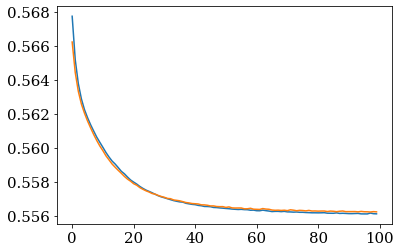

In [27]:
plt.plot( training_hist.history['loss'])
plt.plot( training_hist.history['val_loss'])

In [28]:
w_data = reweight(theta_unknown_S_withback[theta_unknown_S_withback!=dummyval])

34/34 [==============================] - 0s 622us/step


In [29]:
w_data_bgsub_only = w_data

/tmp/ipykernel_3902049/236819712.py:30: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


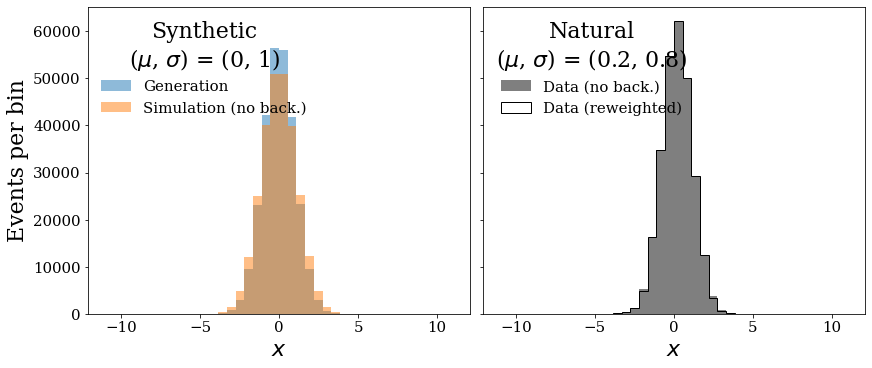

In [30]:
i=0
bins = np.linspace(-11, 11, 41)

fig, ax = plt.subplots(1,
                       2,
                       figsize=(12, 5),
                       constrained_layout=True,
                       sharey=True)

ax[0].set_xlabel(r'$x$')
ax[0].set_ylabel('Events per bin')
ax[0].hist(theta0_G[theta0_G!=dummyval], bins=bins, **plot_style_2, label='Generation')
ax[0].hist(theta0_S[theta0_S!=dummyval], bins=bins, **plot_style_2, label='Simulation (no back.)')
legend = ax[0].legend(
    title='Synthetic\n($\mu$, $\sigma$) = {}'.format(theta0_param),
    loc='upper left',
    frameon=False)
plt.setp(legend.get_title(), multialignment='center')

ax[1].set_xlabel('$x$')
#ax[1].hist(theta_unknown_G[theta_unknown_G!=dummyval], bins=bins, **plot_style_2, label='Truth',color="green")
ax[1].hist(theta_unknown_S[theta_unknown_S!=dummyval], bins=bins, **plot_style_2, label='Data (no back.)',color="black")
ax[1].hist(theta_unknown_S_withback[theta_unknown_S_withback!=dummyval], bins=bins, histtype="step", label='Data (reweighted)',color="black",weights=w_data)
legend = ax[1].legend(
    title='Natural\n($\mu$, $\sigma$) = {}'.format(theta_unknown_param),
    loc='upper left',
    frameon=False)
plt.setp(legend.get_title(), multialignment='center')

fig.show()
plt.savefig("plot_"+str(i)+"_datareweight.pdf")

In [31]:
model_output_bgsub = model.predict(theta_unknown_S_withback[theta_unknown_S_withback!=dummyval], batch_size=10000)

34/34 [==============================] - 0s 648us/step


In [32]:
model_output_bgsub

array([[0.476373  ],
       [0.33195344],
       [0.47795254],
       ...,
       [0.21985865],
       [0.00995671],
       [0.00253275]], dtype=float32)

In [33]:
model_output_bgsub.shape

(330111, 1)

In [34]:
squeezed_model_output = np.squeeze(model_output_bgsub)

In [35]:
squeezed_model_output

array([0.476373  , 0.33195344, 0.47795254, ..., 0.21985865, 0.00995671,
       0.00253275], dtype=float32)

In [36]:
squeezed_model_output.shape

(330111,)

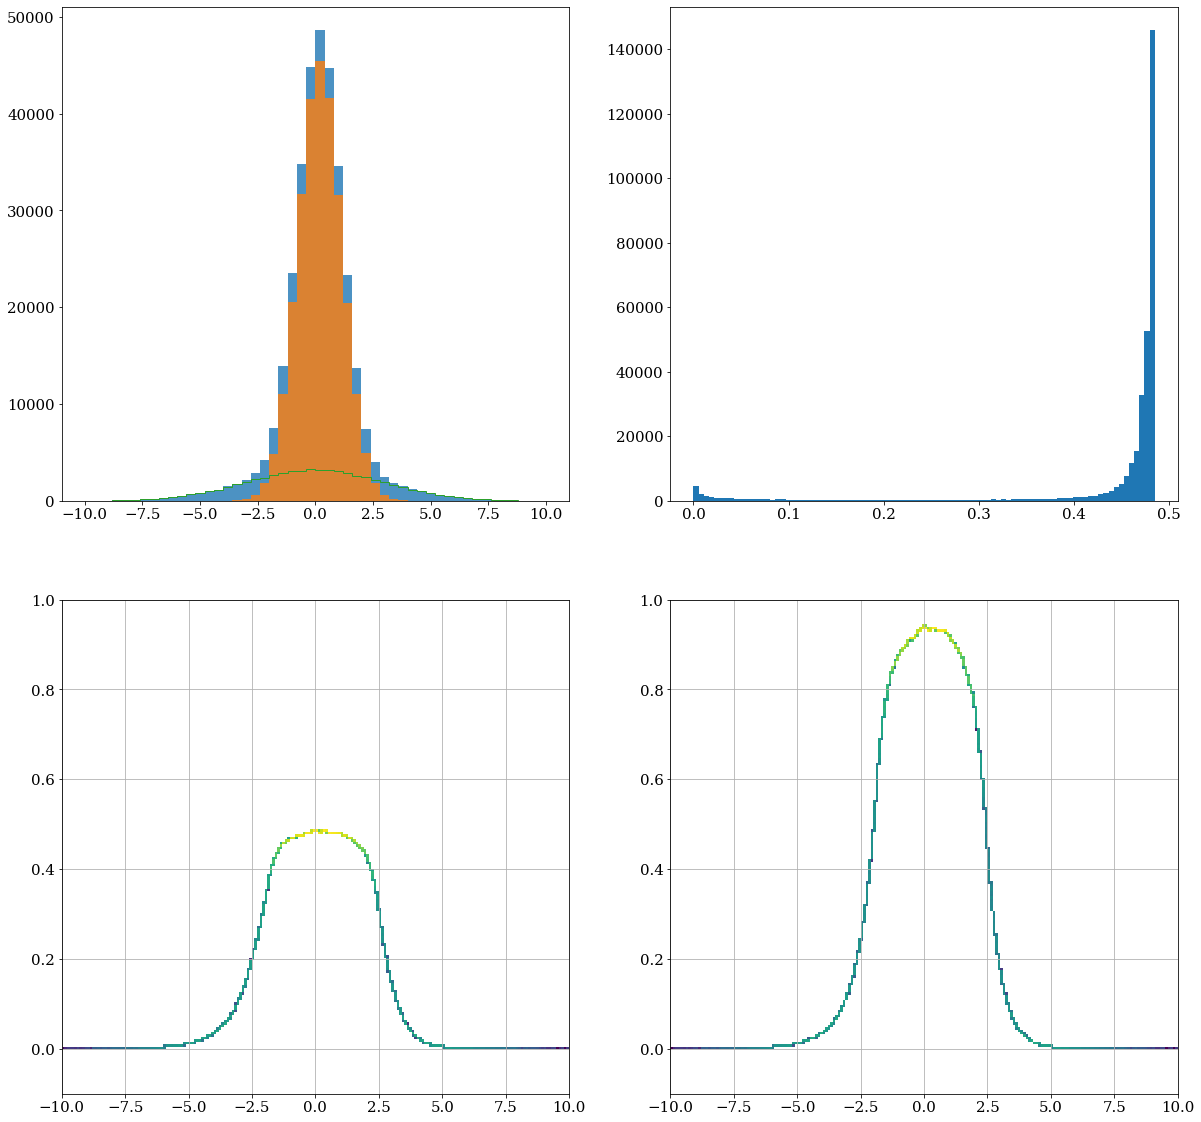

In [37]:
fig,ax = plt.subplots(2,2,figsize=(20,20))



ax[0][0].hist( theta_unknown_S_withback[theta_unknown_S_withback!=dummyval], range=[-10,10], bins=50, alpha=0.8)
ax[0][0].hist( theta_unknown_S[theta_unknown_S!=dummyval], range=[-10,10], bins=50, alpha=0.8)
ax[0][0].hist( theta_background, range=[-10,10], bins=50, histtype="step")

ax[0][1].hist( squeezed_model_output, bins=90 )


ax[1][0].hist2d(theta_unknown_S_withback[theta_unknown_S_withback!=dummyval],
         squeezed_model_output,
         density=True,
         bins=200,
         range=([-10,10],[-0.1,1]),
         norm=mpl.colors.LogNorm())
ax[1][0].grid()

ax[1][1].hist2d(theta_unknown_S_withback[theta_unknown_S_withback!=dummyval],
         w_data,
         density=True,
         bins=200,
         range=([-10,10],[-0.1,1]),
         norm=mpl.colors.LogNorm())
ax[1][1].grid()

plt.show()

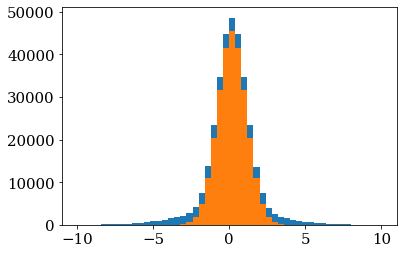

In [38]:
hist_data_all = plt.hist( theta_unknown_S_withback[theta_unknown_S_withback!=dummyval], range=[-10,10], bins=50 )
hist_data_signal = plt.hist( theta_unknown_S[theta_unknown_S!=dummyval], range=[-10,10], bins=50)

In [39]:
hist_data_all

(array([1.4000e+01, 2.0000e+01, 2.5000e+01, 6.7000e+01, 7.3000e+01,
        1.1400e+02, 1.4000e+02, 2.0300e+02, 2.8400e+02, 3.8100e+02,
        5.2300e+02, 6.5500e+02, 7.8300e+02, 9.9200e+02, 1.1490e+03,
        1.4810e+03, 1.7410e+03, 2.1420e+03, 2.8480e+03, 4.1940e+03,
        7.5100e+03, 1.3897e+04, 2.3532e+04, 3.4770e+04, 4.4795e+04,
        4.8632e+04, 4.4746e+04, 3.4633e+04, 2.3352e+04, 1.3683e+04,
        7.4320e+03, 4.0160e+03, 2.4980e+03, 1.8410e+03, 1.4910e+03,
        1.1720e+03, 9.8200e+02, 7.5400e+02, 6.4600e+02, 4.9800e+02,
        3.8600e+02, 2.9300e+02, 2.1100e+02, 1.4900e+02, 1.3100e+02,
        6.4000e+01, 5.7000e+01, 2.8000e+01, 2.0000e+01, 1.5000e+01]),
 array([-10. ,  -9.6,  -9.2,  -8.8,  -8.4,  -8. ,  -7.6,  -7.2,  -6.8,
         -6.4,  -6. ,  -5.6,  -5.2,  -4.8,  -4.4,  -4. ,  -3.6,  -3.2,
         -2.8,  -2.4,  -2. ,  -1.6,  -1.2,  -0.8,  -0.4,   0. ,   0.4,
          0.8,   1.2,   1.6,   2. ,   2.4,   2.8,   3.2,   3.6,   4. ,
          4.4,   4.8,   5.2,   5.6

In [40]:
hist_data_all[0]

array([1.4000e+01, 2.0000e+01, 2.5000e+01, 6.7000e+01, 7.3000e+01,
       1.1400e+02, 1.4000e+02, 2.0300e+02, 2.8400e+02, 3.8100e+02,
       5.2300e+02, 6.5500e+02, 7.8300e+02, 9.9200e+02, 1.1490e+03,
       1.4810e+03, 1.7410e+03, 2.1420e+03, 2.8480e+03, 4.1940e+03,
       7.5100e+03, 1.3897e+04, 2.3532e+04, 3.4770e+04, 4.4795e+04,
       4.8632e+04, 4.4746e+04, 3.4633e+04, 2.3352e+04, 1.3683e+04,
       7.4320e+03, 4.0160e+03, 2.4980e+03, 1.8410e+03, 1.4910e+03,
       1.1720e+03, 9.8200e+02, 7.5400e+02, 6.4600e+02, 4.9800e+02,
       3.8600e+02, 2.9300e+02, 2.1100e+02, 1.4900e+02, 1.3100e+02,
       6.4000e+01, 5.7000e+01, 2.8000e+01, 2.0000e+01, 1.5000e+01])

In [41]:
hist_axis = hist_data_all[1]

In [42]:
hist_axis

array([-10. ,  -9.6,  -9.2,  -8.8,  -8.4,  -8. ,  -7.6,  -7.2,  -6.8,
        -6.4,  -6. ,  -5.6,  -5.2,  -4.8,  -4.4,  -4. ,  -3.6,  -3.2,
        -2.8,  -2.4,  -2. ,  -1.6,  -1.2,  -0.8,  -0.4,   0. ,   0.4,
         0.8,   1.2,   1.6,   2. ,   2.4,   2.8,   3.2,   3.6,   4. ,
         4.4,   4.8,   5.2,   5.6,   6. ,   6.4,   6.8,   7.2,   7.6,
         8. ,   8.4,   8.8,   9.2,   9.6,  10. ])

In [43]:
hist_axis_centers = np.ones(50)
for i in range(0,50):
    hist_axis_centers[i] = 0.5*(hist_axis[i]+hist_axis[i+1])
    #print(i, hist_axis_centers[i])

In [44]:
signal_frac = (hist_data_signal[0])/(hist_data_all[0])

In [45]:
signal_frac

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.00472654, 0.02699598, 0.0821662 , 0.21242978, 0.43729137,
       0.64873502, 0.79290494, 0.87111168, 0.91170549, 0.92762585,
       0.93473433, 0.92998257, 0.9120492 , 0.87615622, 0.80932544,
       0.66913348, 0.45916335, 0.23178543, 0.09016839, 0.02548625,
       0.0059727 , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])

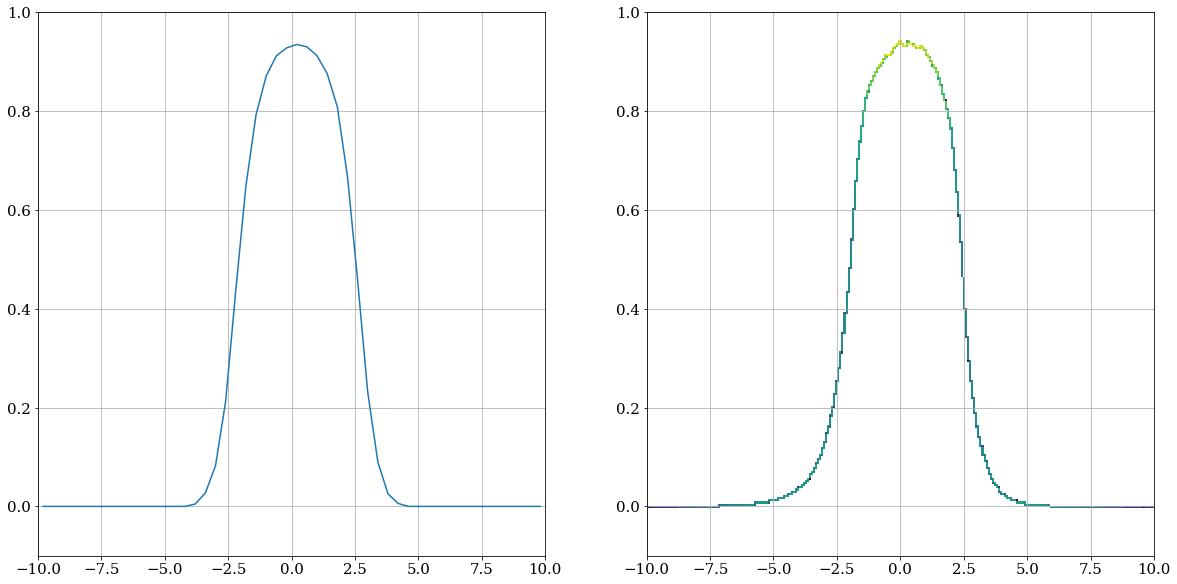

In [46]:
fig,ax = plt.subplots(1,2,figsize=(20,10))


ax[0].plot(hist_axis_centers,signal_frac)
ax[0].set_ylim(-0.1,1)
ax[0].set_xlim(-10,10)
ax[0].grid()

ax[1].hist2d(theta_unknown_S_withback[theta_unknown_S_withback!=dummyval],
         w_data_bgsub_only,
         density=True,
         bins=250,
         range=([-10,10],[-0.1,1]),
         norm=mpl.colors.LogNorm())
ax[1].grid()

plt.show()

In [47]:
of_training_history = np.zeros(shape=(4,2,1000))
of_training_history_val = np.zeros(shape=(4,2,1000))


## OmniFold part starts here

In [48]:
# initial iterative weights are ones
weights_pull = np.ones(len(theta0_S))
weights_push = np.ones(len(theta0_S))

In [49]:
xvals_1 = np.concatenate((theta0_S, theta_unknown_S_withback[theta_unknown_S_withback!=dummyval]))
yvals_1 = np.concatenate((labels0, np.ones(len(theta_unknown_S_withback[theta_unknown_S_withback!=dummyval]))))

In [50]:
%%time



for i in range(iterations):
    print("\n\n\nITERATION: {}\n".format(i + 1))

    

    print("\n\n\n")
    print (strftime("Current time:  %Y-%m-%d %H:%M:%S", gmtime()))
    print("\n\n\n")    
    
    
    
    
    # STEP 1: classify Sim. (which is reweighted by weights_push) to Data
    # weights reweighted Sim. --> Data
    print("\n\n\n Iteration %d,  STEP 1, events that pass reco\n\n\n" % (i+1))
    

    weights_1 = np.concatenate((weights_push, w_data))
    #QUESTION: concatenation here confuses me
    # actual weights for Sim., ones for Data (not MC weights)

    print("Saving :  input_weights_step1_y0[i,:] = weights_push")
    input_weights_step1_y0[i,:] = weights_push
    print("Saving :  input_weights_step1_y1[i,:] = w_data")
    input_weights_step1_y1[i,:] = w_data
    
    
    X_train_1, X_test_1, Y_train_1, Y_test_1, w_train_1, w_test_1 = train_test_split(
        xvals_1, yvals_1, weights_1) #REMINDER: made up of synthetic+measured

#    model.compile(loss='binary_crossentropy',
#                  optimizer='Adam',
#                  metrics=['accuracy'])


    stopwatch.reset()
    stopwatch.start()

    model.compile(loss='binary_crossentropy',
                  optimizer=the_optimizer,
                  metrics=['accuracy'],
                  weighted_metrics=[])    
    
    stopwatch.stop()
    print("\n\n model.compile took this long:  %.2f" % stopwatch.elapsed )

    stopwatch.reset()
    stopwatch.start()
    
    
    
    this_hist = model.fit(X_train_1[X_train_1!=dummyval],
              Y_train_1[X_train_1!=dummyval],
              sample_weight=w_train_1[X_train_1!=dummyval],
              epochs=max_epochs,
              batch_size=batch_size_setval,
              validation_data=(X_test_1[X_test_1!=dummyval], Y_test_1[X_test_1!=dummyval], w_test_1[X_test_1!=dummyval]),
              callbacks=[earlystopping],
              verbose=1)

    stopwatch.stop()
    print("\n\n model.fit took this long:  %.2f" % stopwatch.elapsed )


    
    
    for ei in range(0,len(this_hist.history['loss'])):
        of_training_history[i,0,ei] = this_hist.history['loss'][ei]
        of_training_history_val[i,0,ei] = this_hist.history['val_loss'][ei]
    
    
    weights_pull = weights_push * reweight(theta0_S) 
    #QUESTION: above model used in reweight function (model.predict)?
    #QUESTION: Model trains until synthetic is indistinguishable from data? How does this work? 
    #How are weights then iteratively multiplied?
 

    ##-- owen: save NN output for each iteration, step.
    nn_output[i,0,:] = np.squeeze(  model.predict(theta0_S, batch_size=10000) )



    
    
    
    print("\n\n\n")
    print (strftime("Current time:  %Y-%m-%d %H:%M:%S", gmtime()))
    print("\n\n\n")    
    

    print("\n\n\n Iteration %d,  STEP 1, events that do NOT pass reco\n\n\n" % (i+1))

    ###
    #Need to do something with events that don't pass reco.
    
    #One option is to take the prior:
    #weights_pull[theta0_S==dummyval] = 1. 
    
    #Another option is to assign the average weight: <w|x_true>.  To do this, we need to estimate this quantity.
    xvals_1b = np.concatenate([theta0_G[theta0_S!=dummyval],theta0_G[theta0_S!=dummyval]])
    yvals_1b = np.concatenate([np.ones(len(theta0_G[theta0_S!=dummyval])),np.zeros(len(theta0_G[theta0_S!=dummyval]))])
    weights_1b = np.concatenate([weights_pull[theta0_S!=dummyval],np.ones(len(theta0_G[theta0_S!=dummyval]))])
    
    X_train_1b, X_test_1b, Y_train_1b, Y_test_1b, w_train_1b, w_test_1b = train_test_split(
        xvals_1b, yvals_1b, weights_1b)    
    
#    model.compile(loss='binary_crossentropy',
#                  optimizer='Adam',
#                  metrics=['accuracy'])



    stopwatch.reset()
    stopwatch.start()
    
    model.compile(loss='binary_crossentropy',
                  optimizer=the_optimizer,
                  metrics=['accuracy'],
                  weighted_metrics=[])

    
    
    stopwatch.stop()
    print("\n\n model.compile took this long:  %.2f" % stopwatch.elapsed )

    stopwatch.reset()
    stopwatch.start()
    
    this_hist = model.fit(X_train_1b,
              Y_train_1b,
              sample_weight=w_train_1b,
              epochs=max_epochs,
              batch_size=batch_size_setval,
              validation_data=(X_test_1b, Y_test_1b, w_test_1b),
              callbacks=[earlystopping],
              verbose=1)

    stopwatch.stop()
    print("\n\n model.fit took this long:  %.2f" % stopwatch.elapsed )
        
        
        
        
        
        
        
    
    
    
    
    average_vals = reweight(theta0_G[theta0_S==dummyval])
    weights_pull[theta0_S==dummyval] = average_vals
    ###
    
    
    ##-- owen: the syntax below is a bit confusing.
    #          it is equivalent to weights[i,0,:] I think.  See Python-syntax-testing notebook.
    weights[i, :1, :] = weights_pull
    
    
    
    
    
    
    
    
    
    
    

    
    
    
    print("\n\n\n")
    print (strftime("Current time:  %Y-%m-%d %H:%M:%S", gmtime()))
    print("\n\n\n")    
    
    

    # STEP 2: classify Gen. to reweighted Gen. (which is reweighted by weights_pull)
    # weights Gen. --> reweighted Gen.
    print("\n\n\n Iteration %d,  STEP 2, events that pass reco\n\n\n" % (i+1))

    weights_2 = np.concatenate((np.ones(len(theta0_G)), weights_pull))
    # ones for Gen. (not MC weights), actual weights for (reweighted) Gen.

    
    print(" Saving :  input_weights_step2_y0[i,:] = (np.ones(len(theta0_G)))")
    input_weights_step2_y0[i,:] = (np.ones(len(theta0_G)))
    print(" Saving :  input_weights_y1[i,1,:] = weights_pull ")
    input_weights_step2_y1[i,:] = weights_pull    
    
    
    
    X_train_2, X_test_2, Y_train_2, Y_test_2, w_train_2, w_test_2 = train_test_split(
        xvals_2, yvals_2, weights_2)

#    model.compile(loss='binary_crossentropy',
#                  optimizer='Adam',
#                  metrics=['accuracy'])
    


    stopwatch.reset()
    stopwatch.start()
        
    model.compile(loss='binary_crossentropy',
                  optimizer=the_optimizer,
                  metrics=['accuracy'],
                  weighted_metrics=[])    

    stopwatch.stop()
    print("\n\n model.compile took this long:  %.2f" % stopwatch.elapsed )

    stopwatch.reset()
    stopwatch.start()
    
 
    this_hist = model.fit(X_train_2,
              Y_train_2,
              sample_weight=w_train_2,
              epochs=max_epochs,
              batch_size=batch_size_setval,
              validation_data=(X_test_2, Y_test_2, w_test_2),
              callbacks=[earlystopping],
              verbose=1)

    stopwatch.stop()
    print("\n\n model.fit took this long:  %.2f" % stopwatch.elapsed )
    
    
    
    for ei in range(0,len(this_hist.history['loss'])):
        of_training_history[i,1,ei] = this_hist.history['loss'][ei]
        of_training_history_val[i,1,ei] = this_hist.history['val_loss'][ei]        
    
    
    
    weights_push = reweight(theta0_G)    
    
    ##-- owen: save NN output for each iteration, step.
    nn_output[i,1,:] = np.squeeze(  model.predict(theta0_G, batch_size=10000) )
 





    print("\n\n\n")
    print (strftime("Current time:  %Y-%m-%d %H:%M:%S", gmtime()))
    print("\n\n\n")    
    
    
    print("\n\n\n Iteration %d,  STEP 2, events that do NOT pass reco\n\n\n" % (i+1))
    

    ###
    #Need to do something with events that don't pass truth    
    
    #One option is to take the prior:
    #weights_push[theta0_G==dummyval] = 1. 
    
    #Another option is to assign the average weight: <w|x_reco>.  To do this, we need to estimate this quantity.
    xvals_1b = np.concatenate([theta0_S[theta0_G!=dummyval],theta0_S[theta0_G!=dummyval]])
    yvals_1b = np.concatenate([np.ones(len(theta0_S[theta0_G!=dummyval])),np.zeros(len(theta0_S[theta0_G!=dummyval]))])
    weights_1b = np.concatenate([weights_push[theta0_G!=dummyval],np.ones(len(theta0_S[theta0_G!=dummyval]))])
    
    X_train_1b, X_test_1b, Y_train_1b, Y_test_1b, w_train_1b, w_test_1b = train_test_split(
        xvals_1b, yvals_1b, weights_1b)    
    
    
    
#    model.compile(loss='binary_crossentropy',
#                  optimizer='Adam',
#                  metrics=['accuracy'])

    stopwatch.reset()
    stopwatch.start()
        
    
    model.compile(loss='binary_crossentropy',
                  optimizer=the_optimizer,
                  metrics=['accuracy'],
                  weighted_metrics=[])    

    stopwatch.stop()
    print("\n\n model.compile took this long:  %.2f" % stopwatch.elapsed )

    stopwatch.reset()
    stopwatch.start()
    
     
    
    model.fit(X_train_1b,
              Y_train_1b,
              sample_weight=w_train_1b,
              epochs=max_epochs,
              batch_size=batch_size_setval,
              validation_data=(X_test_1b, Y_test_1b, w_test_1b),
              callbacks=[earlystopping],
              verbose=1)

    stopwatch.stop()
    print("\n\n model.fit took this long:  %.2f" % stopwatch.elapsed )
    
    average_vals = reweight(theta0_S[theta0_G==dummyval])
    weights_push[theta0_G==dummyval] = average_vals
    ###    

    
    ##-- owen: the syntax below is a bit confusing.
    #          it is equivalent to weights[i,1,:] I think.  See Python-syntax-testing notebook.
    
    weights[i, 1:2, :] = weights_push
    
    
    
    
    
    
    

print("\n\n\n")
print (strftime("Current time:  %Y-%m-%d %H:%M:%S", gmtime()))
print("\n\n\n")    
        
    
    




ITERATION: 1





Current time:  2023-02-03 17:02:48







 Iteration 1,  STEP 1, events that pass reco



Saving :  input_weights_step1_y0[i,:] = weights_push
Saving :  input_weights_step1_y1[i,:] = w_data


 model.compile took this long:  0.00
Epoch 1/200
28/28 [==============================] - 24s 864ms/step - loss: 0.6177 - accuracy: 0.5034 - val_loss: 0.6161 - val_accuracy: 0.5326
Epoch 2/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6154 - accuracy: 0.5305 - val_loss: 0.6156 - val_accuracy: 0.5320
Epoch 3/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6151 - accuracy: 0.5299 - val_loss: 0.6154 - val_accuracy: 0.5320
Epoch 4/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6150 - accuracy: 0.5296 - val_loss: 0.6153 - val_accuracy: 0.5310
Epoch 5/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6149 - accuracy: 0.5290 - val_loss: 0.6152 - val_accuracy: 0.5308
Epoch 6/200
28/28 [=======================

Epoch 57/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6144 - accuracy: 0.5286 - val_loss: 0.6148 - val_accuracy: 0.5308
Epoch 58/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6144 - accuracy: 0.5287 - val_loss: 0.6148 - val_accuracy: 0.5305
Epoch 59/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6144 - accuracy: 0.5286 - val_loss: 0.6148 - val_accuracy: 0.5307
Epoch 60/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6144 - accuracy: 0.5286 - val_loss: 0.6148 - val_accuracy: 0.5310
Epoch 61/200
28/28 [==============================] - 0s 3ms/step - loss: 0.6144 - accuracy: 0.5285 - val_loss: 0.6148 - val_accuracy: 0.5306
Epoch 62/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6144 - accuracy: 0.5288 - val_loss: 0.6148 - val_accuracy: 0.5308
Epoch 63/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6144 - accuracy: 0.5285 - val_loss: 0.6148 - val_accuracy: 0.5309
Epoch 

28/28 [==============================] - 0s 4ms/step - loss: 0.6143 - accuracy: 0.5286 - val_loss: 0.6147 - val_accuracy: 0.5305
Epoch 115/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6143 - accuracy: 0.5285 - val_loss: 0.6147 - val_accuracy: 0.5307
Epoch 116/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6143 - accuracy: 0.5283 - val_loss: 0.6147 - val_accuracy: 0.5306
Epoch 117/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6143 - accuracy: 0.5287 - val_loss: 0.6147 - val_accuracy: 0.5305
Epoch 118/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6143 - accuracy: 0.5284 - val_loss: 0.6147 - val_accuracy: 0.5307
Epoch 119/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6143 - accuracy: 0.5285 - val_loss: 0.6147 - val_accuracy: 0.5305
Epoch 120/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6143 - accuracy: 0.5285 - val_loss: 0.6147 - val_accuracy: 0.5309
Epoch 121/200

28/28 [==============================] - 0s 4ms/step - loss: 0.6142 - accuracy: 0.5288 - val_loss: 0.6146 - val_accuracy: 0.5298
Epoch 172/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6142 - accuracy: 0.5281 - val_loss: 0.6146 - val_accuracy: 0.5309
Epoch 173/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6142 - accuracy: 0.5286 - val_loss: 0.6146 - val_accuracy: 0.5311
Epoch 174/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6142 - accuracy: 0.5286 - val_loss: 0.6146 - val_accuracy: 0.5307
Epoch 175/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6142 - accuracy: 0.5286 - val_loss: 0.6146 - val_accuracy: 0.5310
Epoch 176/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6142 - accuracy: 0.5286 - val_loss: 0.6146 - val_accuracy: 0.5308
Epoch 177/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6142 - accuracy: 0.5285 - val_loss: 0.6146 - val_accuracy: 0.5314
Epoch 178/200

25/25 [==============================] - 0s 4ms/step - loss: 0.6910 - accuracy: 0.4995 - val_loss: 0.6905 - val_accuracy: 0.5004
Epoch 27/200
25/25 [==============================] - 0s 4ms/step - loss: 0.6910 - accuracy: 0.4997 - val_loss: 0.6905 - val_accuracy: 0.5001
Epoch 28/200
25/25 [==============================] - 0s 4ms/step - loss: 0.6910 - accuracy: 0.4999 - val_loss: 0.6905 - val_accuracy: 0.5003
Epoch 29/200
25/25 [==============================] - 0s 4ms/step - loss: 0.6910 - accuracy: 0.4995 - val_loss: 0.6905 - val_accuracy: 0.5000
Epoch 30/200
25/25 [==============================] - 0s 3ms/step - loss: 0.6910 - accuracy: 0.4997 - val_loss: 0.6905 - val_accuracy: 0.5008
Epoch 31/200
25/25 [==============================] - 0s 4ms/step - loss: 0.6910 - accuracy: 0.4999 - val_loss: 0.6905 - val_accuracy: 0.5002
Epoch 32/200
25/25 [==============================] - 0s 4ms/step - loss: 0.6910 - accuracy: 0.5001 - val_loss: 0.6905 - val_accuracy: 0.5005
Epoch 33/200
25/25 

28/28 [==============================] - 0s 4ms/step - loss: 0.6907 - accuracy: 0.4998 - val_loss: 0.6914 - val_accuracy: 0.5011
Epoch 15/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6907 - accuracy: 0.4996 - val_loss: 0.6914 - val_accuracy: 0.5010
Epoch 16/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6907 - accuracy: 0.4995 - val_loss: 0.6914 - val_accuracy: 0.5008
Epoch 17/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6907 - accuracy: 0.4999 - val_loss: 0.6915 - val_accuracy: 0.5009
Epoch 18/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6907 - accuracy: 0.4995 - val_loss: 0.6914 - val_accuracy: 0.5010
Epoch 19/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6907 - accuracy: 0.5000 - val_loss: 0.6914 - val_accuracy: 0.5010
Epoch 20/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6907 - accuracy: 0.4997 - val_loss: 0.6914 - val_accuracy: 0.5010
Epoch 21/200
28/28 

25/25 [==============================] - 0s 4ms/step - loss: 0.6939 - accuracy: 0.4997 - val_loss: 0.6942 - val_accuracy: 0.5020
Epoch 28/200
25/25 [==============================] - 0s 4ms/step - loss: 0.6939 - accuracy: 0.4991 - val_loss: 0.6942 - val_accuracy: 0.5011
Epoch 29/200
25/25 [==============================] - 0s 4ms/step - loss: 0.6939 - accuracy: 0.4995 - val_loss: 0.6942 - val_accuracy: 0.5012
Epoch 30/200
25/25 [==============================] - 0s 4ms/step - loss: 0.6939 - accuracy: 0.4994 - val_loss: 0.6942 - val_accuracy: 0.5018
Epoch 31/200
25/25 [==============================] - 0s 4ms/step - loss: 0.6939 - accuracy: 0.4991 - val_loss: 0.6942 - val_accuracy: 0.5018
Epoch 32/200
25/25 [==============================] - 0s 4ms/step - loss: 0.6939 - accuracy: 0.4995 - val_loss: 0.6942 - val_accuracy: 0.5018
Epoch 33/200
25/25 [==============================] - 0s 4ms/step - loss: 0.6939 - accuracy: 0.4992 - val_loss: 0.6942 - val_accuracy: 0.5012
Epoch 34/200
25/25 

28/28 [==============================] - 0s 4ms/step - loss: 0.6279 - accuracy: 0.5181 - val_loss: 0.6275 - val_accuracy: 0.5233
Epoch 11/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6279 - accuracy: 0.5199 - val_loss: 0.6275 - val_accuracy: 0.5199
Epoch 12/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6279 - accuracy: 0.5208 - val_loss: 0.6275 - val_accuracy: 0.5212
Epoch 13/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6279 - accuracy: 0.5213 - val_loss: 0.6275 - val_accuracy: 0.5221
Epoch 14/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6279 - accuracy: 0.5217 - val_loss: 0.6275 - val_accuracy: 0.5259
Epoch 15/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6279 - accuracy: 0.5230 - val_loss: 0.6275 - val_accuracy: 0.5256
Epoch 16/200
28/28 [==============================] - 0s 3ms/step - loss: 0.6279 - accuracy: 0.5238 - val_loss: 0.6275 - val_accuracy: 0.5247
Epoch 17/200
28/28 

Epoch 68/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6278 - accuracy: 0.5268 - val_loss: 0.6275 - val_accuracy: 0.5335
Epoch 69/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6278 - accuracy: 0.5288 - val_loss: 0.6275 - val_accuracy: 0.5333
Epoch 70/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6278 - accuracy: 0.5288 - val_loss: 0.6275 - val_accuracy: 0.5242
Epoch 71/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6278 - accuracy: 0.5285 - val_loss: 0.6275 - val_accuracy: 0.5318
Epoch 72/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6278 - accuracy: 0.5275 - val_loss: 0.6275 - val_accuracy: 0.5271
Epoch 73/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6278 - accuracy: 0.5308 - val_loss: 0.6275 - val_accuracy: 0.5268
Epoch 74/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6278 - accuracy: 0.5291 - val_loss: 0.6275 - val_accuracy: 0.5297
Epoch 

28/28 [==============================] - 0s 4ms/step - loss: 0.6278 - accuracy: 0.5289 - val_loss: 0.6275 - val_accuracy: 0.5324
Epoch 126/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6278 - accuracy: 0.5302 - val_loss: 0.6275 - val_accuracy: 0.5282
Epoch 127/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6278 - accuracy: 0.5294 - val_loss: 0.6275 - val_accuracy: 0.5308
Epoch 128/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6278 - accuracy: 0.5283 - val_loss: 0.6275 - val_accuracy: 0.5305
Epoch 129/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6278 - accuracy: 0.5310 - val_loss: 0.6275 - val_accuracy: 0.5275
Epoch 130/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6278 - accuracy: 0.5289 - val_loss: 0.6275 - val_accuracy: 0.5310
Epoch 131/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6278 - accuracy: 0.5294 - val_loss: 0.6275 - val_accuracy: 0.5327
Epoch 132/200

28/28 [==============================] - 0s 4ms/step - loss: 0.6278 - accuracy: 0.5321 - val_loss: 0.6275 - val_accuracy: 0.5259
Epoch 183/200
28/28 [==============================] - 0s 3ms/step - loss: 0.6278 - accuracy: 0.5296 - val_loss: 0.6275 - val_accuracy: 0.5322
Epoch 184/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6278 - accuracy: 0.5283 - val_loss: 0.6275 - val_accuracy: 0.5322
Epoch 185/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6278 - accuracy: 0.5312 - val_loss: 0.6275 - val_accuracy: 0.5279
Epoch 186/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6278 - accuracy: 0.5282 - val_loss: 0.6275 - val_accuracy: 0.5329
Epoch 187/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6278 - accuracy: 0.5323 - val_loss: 0.6275 - val_accuracy: 0.5271
Epoch 188/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6278 - accuracy: 0.5312 - val_loss: 0.6275 - val_accuracy: 0.5269
Epoch 189/200

Epoch 38/200
25/25 [==============================] - 0s 4ms/step - loss: 0.6807 - accuracy: 0.5002 - val_loss: 0.6810 - val_accuracy: 0.4997
Epoch 39/200
25/25 [==============================] - 0s 3ms/step - loss: 0.6807 - accuracy: 0.4997 - val_loss: 0.6810 - val_accuracy: 0.4996
Epoch 40/200
25/25 [==============================] - 0s 4ms/step - loss: 0.6807 - accuracy: 0.4998 - val_loss: 0.6810 - val_accuracy: 0.4999
Epoch 41/200
25/25 [==============================] - 0s 4ms/step - loss: 0.6807 - accuracy: 0.4998 - val_loss: 0.6810 - val_accuracy: 0.4997
Epoch 42/200
25/25 [==============================] - 0s 4ms/step - loss: 0.6807 - accuracy: 0.4998 - val_loss: 0.6810 - val_accuracy: 0.5009
Epoch 43/200
25/25 [==============================] - 0s 4ms/step - loss: 0.6807 - accuracy: 0.4993 - val_loss: 0.6810 - val_accuracy: 0.5011
Epoch 44/200
25/25 [==============================] - 0s 4ms/step - loss: 0.6807 - accuracy: 0.4996 - val_loss: 0.6810 - val_accuracy: 0.5010
Epoch 

Epoch 96/200
25/25 [==============================] - 0s 4ms/step - loss: 0.6807 - accuracy: 0.4997 - val_loss: 0.6811 - val_accuracy: 0.4998
Epoch 97/200
25/25 [==============================] - 0s 4ms/step - loss: 0.6807 - accuracy: 0.5000 - val_loss: 0.6810 - val_accuracy: 0.4998
Epoch 98/200
25/25 [==============================] - 0s 4ms/step - loss: 0.6807 - accuracy: 0.4994 - val_loss: 0.6810 - val_accuracy: 0.5010
Epoch 99/200
25/25 [==============================] - 0s 4ms/step - loss: 0.6807 - accuracy: 0.4996 - val_loss: 0.6810 - val_accuracy: 0.5010
Epoch 100/200
25/25 [==============================] - 0s 4ms/step - loss: 0.6807 - accuracy: 0.5000 - val_loss: 0.6810 - val_accuracy: 0.5011
Epoch 101/200
25/25 [==============================] - 0s 4ms/step - loss: 0.6807 - accuracy: 0.4997 - val_loss: 0.6810 - val_accuracy: 0.5009
Epoch 102/200
25/25 [==============================] - 0s 4ms/step - loss: 0.6807 - accuracy: 0.4999 - val_loss: 0.6810 - val_accuracy: 0.5010
Epo

25/25 [==============================] - 0s 4ms/step - loss: 0.6807 - accuracy: 0.5001 - val_loss: 0.6810 - val_accuracy: 0.4998
Epoch 154/200
25/25 [==============================] - 0s 4ms/step - loss: 0.6807 - accuracy: 0.5002 - val_loss: 0.6811 - val_accuracy: 0.4999
Epoch 155/200
25/25 [==============================] - 0s 4ms/step - loss: 0.6807 - accuracy: 0.5004 - val_loss: 0.6810 - val_accuracy: 0.5008
Epoch 156/200
25/25 [==============================] - 0s 3ms/step - loss: 0.6807 - accuracy: 0.4999 - val_loss: 0.6810 - val_accuracy: 0.5010
Epoch 157/200
25/25 [==============================] - 0s 3ms/step - loss: 0.6808 - accuracy: 0.4994 - val_loss: 0.6810 - val_accuracy: 0.4994
Epoch 158/200
25/25 [==============================] - 0s 3ms/step - loss: 0.6808 - accuracy: 0.4996 - val_loss: 0.6810 - val_accuracy: 0.5010
Epoch 159/200
25/25 [==============================] - 0s 4ms/step - loss: 0.6807 - accuracy: 0.4996 - val_loss: 0.6810 - val_accuracy: 0.4999
Epoch 159: ea

Epoch 1/200
25/25 [==============================] - 20s 840ms/step - loss: 0.6860 - accuracy: 0.5002 - val_loss: 0.6863 - val_accuracy: 0.4986
Epoch 2/200
25/25 [==============================] - 0s 4ms/step - loss: 0.6854 - accuracy: 0.5001 - val_loss: 0.6863 - val_accuracy: 0.4986
Epoch 3/200
25/25 [==============================] - 0s 4ms/step - loss: 0.6854 - accuracy: 0.4999 - val_loss: 0.6862 - val_accuracy: 0.4990
Epoch 4/200
25/25 [==============================] - 0s 3ms/step - loss: 0.6854 - accuracy: 0.5003 - val_loss: 0.6862 - val_accuracy: 0.4987
Epoch 5/200
25/25 [==============================] - 0s 3ms/step - loss: 0.6854 - accuracy: 0.5003 - val_loss: 0.6862 - val_accuracy: 0.4990
Epoch 6/200
25/25 [==============================] - 0s 3ms/step - loss: 0.6854 - accuracy: 0.5004 - val_loss: 0.6862 - val_accuracy: 0.4991
Epoch 7/200
25/25 [==============================] - 0s 3ms/step - loss: 0.6853 - accuracy: 0.5002 - val_loss: 0.6862 - val_accuracy: 0.4987
Epoch 8/20

Epoch 59/200
25/25 [==============================] - 0s 4ms/step - loss: 0.6853 - accuracy: 0.5003 - val_loss: 0.6862 - val_accuracy: 0.4989
Epoch 60/200
25/25 [==============================] - 0s 4ms/step - loss: 0.6853 - accuracy: 0.5003 - val_loss: 0.6862 - val_accuracy: 0.4986
Epoch 61/200
25/25 [==============================] - 0s 4ms/step - loss: 0.6853 - accuracy: 0.5006 - val_loss: 0.6862 - val_accuracy: 0.4987
Epoch 62/200
25/25 [==============================] - 0s 4ms/step - loss: 0.6853 - accuracy: 0.5007 - val_loss: 0.6862 - val_accuracy: 0.4987
Epoch 63/200
25/25 [==============================] - 0s 4ms/step - loss: 0.6853 - accuracy: 0.5006 - val_loss: 0.6863 - val_accuracy: 0.4989
Epoch 64/200
25/25 [==============================] - 0s 4ms/step - loss: 0.6853 - accuracy: 0.5004 - val_loss: 0.6862 - val_accuracy: 0.4989
Epoch 65/200
25/25 [==============================] - 0s 4ms/step - loss: 0.6853 - accuracy: 0.5002 - val_loss: 0.6862 - val_accuracy: 0.4987
Epoch 

28/28 [==============================] - 0s 4ms/step - loss: 0.6241 - accuracy: 0.5339 - val_loss: 0.6234 - val_accuracy: 0.5296
Epoch 48/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6241 - accuracy: 0.5315 - val_loss: 0.6234 - val_accuracy: 0.5312
Epoch 49/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6241 - accuracy: 0.5373 - val_loss: 0.6235 - val_accuracy: 0.5188
Epoch 50/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6241 - accuracy: 0.5284 - val_loss: 0.6234 - val_accuracy: 0.5323
Epoch 51/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6241 - accuracy: 0.5333 - val_loss: 0.6234 - val_accuracy: 0.5300
Epoch 52/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6241 - accuracy: 0.5348 - val_loss: 0.6234 - val_accuracy: 0.5361
Epoch 53/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6241 - accuracy: 0.5301 - val_loss: 0.6234 - val_accuracy: 0.5387
Epoch 54/200
28/28 

Epoch 105/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6241 - accuracy: 0.5391 - val_loss: 0.6234 - val_accuracy: 0.5383
Epoch 106/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6241 - accuracy: 0.5391 - val_loss: 0.6234 - val_accuracy: 0.5369
Epoch 107/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6241 - accuracy: 0.5425 - val_loss: 0.6234 - val_accuracy: 0.5397
Epoch 108/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6241 - accuracy: 0.5370 - val_loss: 0.6234 - val_accuracy: 0.5438
Epoch 109/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6241 - accuracy: 0.5402 - val_loss: 0.6234 - val_accuracy: 0.5428
Epoch 110/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6241 - accuracy: 0.5390 - val_loss: 0.6234 - val_accuracy: 0.5374
Epoch 111/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6241 - accuracy: 0.5415 - val_loss: 0.6235 - val_accuracy: 0.5258

28/28 [==============================] - 0s 4ms/step - loss: 0.6241 - accuracy: 0.5429 - val_loss: 0.6234 - val_accuracy: 0.5320
Epoch 163/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6241 - accuracy: 0.5390 - val_loss: 0.6234 - val_accuracy: 0.5406
Epoch 164/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6241 - accuracy: 0.5411 - val_loss: 0.6234 - val_accuracy: 0.5478
Epoch 165/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6241 - accuracy: 0.5445 - val_loss: 0.6234 - val_accuracy: 0.5411
Epoch 166/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6241 - accuracy: 0.5431 - val_loss: 0.6234 - val_accuracy: 0.5435
Epoch 167/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6241 - accuracy: 0.5400 - val_loss: 0.6234 - val_accuracy: 0.5489
Epoch 168/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6241 - accuracy: 0.5461 - val_loss: 0.6234 - val_accuracy: 0.5375
Epoch 169/200

25/25 [==============================] - 0s 4ms/step - loss: 0.6801 - accuracy: 0.5003 - val_loss: 0.6802 - val_accuracy: 0.4985
Epoch 18/200
25/25 [==============================] - 0s 3ms/step - loss: 0.6801 - accuracy: 0.5004 - val_loss: 0.6802 - val_accuracy: 0.4996
Epoch 19/200
25/25 [==============================] - 0s 4ms/step - loss: 0.6801 - accuracy: 0.5001 - val_loss: 0.6802 - val_accuracy: 0.4985
Epoch 20/200
25/25 [==============================] - 0s 4ms/step - loss: 0.6801 - accuracy: 0.5001 - val_loss: 0.6802 - val_accuracy: 0.4985
Epoch 21/200
25/25 [==============================] - 0s 4ms/step - loss: 0.6801 - accuracy: 0.5002 - val_loss: 0.6802 - val_accuracy: 0.4994
Epoch 22/200
25/25 [==============================] - 0s 4ms/step - loss: 0.6801 - accuracy: 0.5001 - val_loss: 0.6802 - val_accuracy: 0.4986
Epoch 23/200
25/25 [==============================] - 0s 4ms/step - loss: 0.6801 - accuracy: 0.5006 - val_loss: 0.6802 - val_accuracy: 0.4987
Epoch 24/200
25/25 

Epoch 75/200
25/25 [==============================] - 0s 4ms/step - loss: 0.6801 - accuracy: 0.5000 - val_loss: 0.6801 - val_accuracy: 0.4994
Epoch 76/200
25/25 [==============================] - 0s 4ms/step - loss: 0.6801 - accuracy: 0.5001 - val_loss: 0.6801 - val_accuracy: 0.4985
Epoch 77/200
25/25 [==============================] - 0s 4ms/step - loss: 0.6801 - accuracy: 0.5003 - val_loss: 0.6801 - val_accuracy: 0.4985
Epoch 78/200
25/25 [==============================] - 0s 5ms/step - loss: 0.6801 - accuracy: 0.4999 - val_loss: 0.6801 - val_accuracy: 0.4993
Epoch 79/200
25/25 [==============================] - 0s 4ms/step - loss: 0.6801 - accuracy: 0.5008 - val_loss: 0.6801 - val_accuracy: 0.4985
Epoch 80/200
25/25 [==============================] - 0s 4ms/step - loss: 0.6801 - accuracy: 0.4997 - val_loss: 0.6802 - val_accuracy: 0.4987
Epoch 81/200
25/25 [==============================] - 0s 4ms/step - loss: 0.6801 - accuracy: 0.5005 - val_loss: 0.6801 - val_accuracy: 0.4994
Epoch 

25/25 [==============================] - 0s 4ms/step - loss: 0.6801 - accuracy: 0.5003 - val_loss: 0.6801 - val_accuracy: 0.4987
Epoch 133/200
25/25 [==============================] - 0s 4ms/step - loss: 0.6801 - accuracy: 0.5002 - val_loss: 0.6801 - val_accuracy: 0.4986
Epoch 134/200
25/25 [==============================] - 0s 4ms/step - loss: 0.6801 - accuracy: 0.5004 - val_loss: 0.6801 - val_accuracy: 0.4993
Epoch 135/200
25/25 [==============================] - 0s 4ms/step - loss: 0.6801 - accuracy: 0.4999 - val_loss: 0.6801 - val_accuracy: 0.4986
Epoch 136/200
25/25 [==============================] - 0s 4ms/step - loss: 0.6801 - accuracy: 0.5005 - val_loss: 0.6801 - val_accuracy: 0.4986
Epoch 137/200
25/25 [==============================] - 0s 4ms/step - loss: 0.6801 - accuracy: 0.5003 - val_loss: 0.6801 - val_accuracy: 0.4986
Epoch 138/200
25/25 [==============================] - 0s 4ms/step - loss: 0.6801 - accuracy: 0.5008 - val_loss: 0.6801 - val_accuracy: 0.4986
Epoch 139/200

25/25 [==============================] - 0s 4ms/step - loss: 0.6801 - accuracy: 0.5004 - val_loss: 0.6801 - val_accuracy: 0.4986
Epoch 190/200
25/25 [==============================] - 0s 3ms/step - loss: 0.6801 - accuracy: 0.5001 - val_loss: 0.6801 - val_accuracy: 0.4993
Epoch 191/200
25/25 [==============================] - 0s 4ms/step - loss: 0.6801 - accuracy: 0.5006 - val_loss: 0.6801 - val_accuracy: 0.4993
Epoch 192/200
25/25 [==============================] - 0s 4ms/step - loss: 0.6801 - accuracy: 0.5004 - val_loss: 0.6801 - val_accuracy: 0.4994
Epoch 193/200
25/25 [==============================] - 0s 4ms/step - loss: 0.6801 - accuracy: 0.4999 - val_loss: 0.6801 - val_accuracy: 0.4987
Epoch 194/200
25/25 [==============================] - 0s 4ms/step - loss: 0.6801 - accuracy: 0.5002 - val_loss: 0.6801 - val_accuracy: 0.4984
Epoch 195/200
25/25 [==============================] - 0s 4ms/step - loss: 0.6801 - accuracy: 0.4998 - val_loss: 0.6801 - val_accuracy: 0.4995
Epoch 196/200

28/28 [==============================] - 0s 4ms/step - loss: 0.6801 - accuracy: 0.4992 - val_loss: 0.6793 - val_accuracy: 0.5014
Epoch 45/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6801 - accuracy: 0.4998 - val_loss: 0.6792 - val_accuracy: 0.5014
Epoch 46/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6801 - accuracy: 0.4991 - val_loss: 0.6792 - val_accuracy: 0.5013
Epoch 46: early stopping


 model.fit took this long:  93.80
30/30 [==============================] - 0s 636us/step




Current time:  2023-02-03 17:21:23







 Iteration 3,  STEP 2, events that do NOT pass reco





 model.compile took this long:  0.00
Epoch 1/200
25/25 [==============================] - 22s 887ms/step - loss: 0.6861 - accuracy: 0.4991 - val_loss: 0.6848 - val_accuracy: 0.5026
Epoch 2/200
25/25 [==============================] - 0s 3ms/step - loss: 0.6852 - accuracy: 0.4983 - val_loss: 0.6848 - val_accuracy: 0.5028
Epoch 3/200
25/25 [===========================

25/25 [==============================] - 0s 4ms/step - loss: 0.6850 - accuracy: 0.4992 - val_loss: 0.6846 - val_accuracy: 0.5027
Epoch 53/200
25/25 [==============================] - 0s 3ms/step - loss: 0.6850 - accuracy: 0.4988 - val_loss: 0.6846 - val_accuracy: 0.5027
Epoch 54/200
25/25 [==============================] - 0s 4ms/step - loss: 0.6850 - accuracy: 0.4990 - val_loss: 0.6847 - val_accuracy: 0.5026
Epoch 55/200
25/25 [==============================] - 0s 4ms/step - loss: 0.6850 - accuracy: 0.4995 - val_loss: 0.6846 - val_accuracy: 0.5024
Epoch 56/200
25/25 [==============================] - 0s 4ms/step - loss: 0.6850 - accuracy: 0.4989 - val_loss: 0.6846 - val_accuracy: 0.5028
Epoch 57/200
25/25 [==============================] - 0s 4ms/step - loss: 0.6850 - accuracy: 0.4988 - val_loss: 0.6846 - val_accuracy: 0.5027
Epoch 58/200
25/25 [==============================] - 0s 4ms/step - loss: 0.6850 - accuracy: 0.4994 - val_loss: 0.6846 - val_accuracy: 0.5024
Epoch 59/200
25/25 

28/28 [==============================] - 0s 3ms/step - loss: 0.6251 - accuracy: 0.5217 - val_loss: 0.6251 - val_accuracy: 0.5227
Epoch 5/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6250 - accuracy: 0.5333 - val_loss: 0.6251 - val_accuracy: 0.5328
Epoch 6/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6250 - accuracy: 0.5247 - val_loss: 0.6251 - val_accuracy: 0.5303
Epoch 7/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6250 - accuracy: 0.5322 - val_loss: 0.6251 - val_accuracy: 0.5257
Epoch 8/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6250 - accuracy: 0.5332 - val_loss: 0.6251 - val_accuracy: 0.5298
Epoch 9/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6250 - accuracy: 0.5376 - val_loss: 0.6251 - val_accuracy: 0.5264
Epoch 10/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6250 - accuracy: 0.5323 - val_loss: 0.6251 - val_accuracy: 0.5393
Epoch 11/200
28/28 [====

Epoch 62/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6250 - accuracy: 0.5465 - val_loss: 0.6251 - val_accuracy: 0.5390
Epoch 63/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6250 - accuracy: 0.5340 - val_loss: 0.6251 - val_accuracy: 0.5376
Epoch 64/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6250 - accuracy: 0.5351 - val_loss: 0.6251 - val_accuracy: 0.5336
Epoch 65/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6250 - accuracy: 0.5402 - val_loss: 0.6251 - val_accuracy: 0.5375
Epoch 66/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6250 - accuracy: 0.5395 - val_loss: 0.6251 - val_accuracy: 0.5406
Epoch 67/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6250 - accuracy: 0.5398 - val_loss: 0.6251 - val_accuracy: 0.5339
Epoch 68/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6250 - accuracy: 0.5322 - val_loss: 0.6251 - val_accuracy: 0.5243
Epoch 

25/25 [==============================] - 0s 4ms/step - loss: 0.6784 - accuracy: 0.4993 - val_loss: 0.6785 - val_accuracy: 0.5001
Epoch 42/200
25/25 [==============================] - 0s 4ms/step - loss: 0.6784 - accuracy: 0.4995 - val_loss: 0.6785 - val_accuracy: 0.5005
Epoch 43/200
25/25 [==============================] - 0s 4ms/step - loss: 0.6784 - accuracy: 0.5002 - val_loss: 0.6786 - val_accuracy: 0.5006
Epoch 44/200
25/25 [==============================] - 0s 4ms/step - loss: 0.6784 - accuracy: 0.4995 - val_loss: 0.6785 - val_accuracy: 0.5006
Epoch 45/200
25/25 [==============================] - 0s 4ms/step - loss: 0.6784 - accuracy: 0.4996 - val_loss: 0.6785 - val_accuracy: 0.5003
Epoch 46/200
25/25 [==============================] - 0s 4ms/step - loss: 0.6784 - accuracy: 0.4998 - val_loss: 0.6785 - val_accuracy: 0.5001
Epoch 47/200
25/25 [==============================] - 0s 4ms/step - loss: 0.6784 - accuracy: 0.4998 - val_loss: 0.6786 - val_accuracy: 0.5005
Epoch 48/200
25/25 

Epoch 99/200
25/25 [==============================] - 0s 4ms/step - loss: 0.6784 - accuracy: 0.4996 - val_loss: 0.6785 - val_accuracy: 0.5002
Epoch 100/200
25/25 [==============================] - 0s 4ms/step - loss: 0.6784 - accuracy: 0.4998 - val_loss: 0.6785 - val_accuracy: 0.5004
Epoch 101/200
25/25 [==============================] - 0s 4ms/step - loss: 0.6784 - accuracy: 0.4995 - val_loss: 0.6785 - val_accuracy: 0.5003
Epoch 102/200
25/25 [==============================] - 0s 4ms/step - loss: 0.6784 - accuracy: 0.4996 - val_loss: 0.6785 - val_accuracy: 0.5002
Epoch 103/200
25/25 [==============================] - 0s 4ms/step - loss: 0.6784 - accuracy: 0.4997 - val_loss: 0.6785 - val_accuracy: 0.5004
Epoch 104/200
25/25 [==============================] - 0s 4ms/step - loss: 0.6784 - accuracy: 0.5002 - val_loss: 0.6785 - val_accuracy: 0.5007
Epoch 105/200
25/25 [==============================] - 0s 4ms/step - loss: 0.6784 - accuracy: 0.4997 - val_loss: 0.6785 - val_accuracy: 0.5004


25/25 [==============================] - 0s 4ms/step - loss: 0.6783 - accuracy: 0.4998 - val_loss: 0.6785 - val_accuracy: 0.5002
Epoch 157/200
25/25 [==============================] - 0s 4ms/step - loss: 0.6784 - accuracy: 0.5003 - val_loss: 0.6785 - val_accuracy: 0.5002
Epoch 158/200
25/25 [==============================] - 0s 4ms/step - loss: 0.6783 - accuracy: 0.4998 - val_loss: 0.6786 - val_accuracy: 0.5004
Epoch 159/200
25/25 [==============================] - 0s 4ms/step - loss: 0.6784 - accuracy: 0.4999 - val_loss: 0.6785 - val_accuracy: 0.5002
Epoch 160/200
25/25 [==============================] - 0s 4ms/step - loss: 0.6784 - accuracy: 0.5001 - val_loss: 0.6785 - val_accuracy: 0.5003
Epoch 161/200
25/25 [==============================] - 0s 3ms/step - loss: 0.6784 - accuracy: 0.4997 - val_loss: 0.6785 - val_accuracy: 0.5002
Epoch 162/200
25/25 [==============================] - 0s 4ms/step - loss: 0.6784 - accuracy: 0.4997 - val_loss: 0.6785 - val_accuracy: 0.5007
Epoch 163/200

Epoch 14/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6784 - accuracy: 0.5002 - val_loss: 0.6787 - val_accuracy: 0.4994
Epoch 15/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6784 - accuracy: 0.4999 - val_loss: 0.6787 - val_accuracy: 0.5000
Epoch 16/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6784 - accuracy: 0.4998 - val_loss: 0.6787 - val_accuracy: 0.4993
Epoch 17/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6784 - accuracy: 0.4999 - val_loss: 0.6787 - val_accuracy: 0.5003
Epoch 18/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6784 - accuracy: 0.4999 - val_loss: 0.6787 - val_accuracy: 0.4999
Epoch 19/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6784 - accuracy: 0.4999 - val_loss: 0.6787 - val_accuracy: 0.4994
Epoch 20/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6784 - accuracy: 0.5000 - val_loss: 0.6787 - val_accuracy: 0.4999
Epoch 

25/25 [==============================] - 0s 4ms/step - loss: 0.6831 - accuracy: 0.5002 - val_loss: 0.6827 - val_accuracy: 0.4992
Epoch 20/200
25/25 [==============================] - 0s 3ms/step - loss: 0.6831 - accuracy: 0.4999 - val_loss: 0.6827 - val_accuracy: 0.4995
Epoch 21/200
25/25 [==============================] - 0s 3ms/step - loss: 0.6831 - accuracy: 0.5006 - val_loss: 0.6827 - val_accuracy: 0.4991
Epoch 22/200
25/25 [==============================] - 0s 3ms/step - loss: 0.6831 - accuracy: 0.5002 - val_loss: 0.6827 - val_accuracy: 0.4991
Epoch 23/200
25/25 [==============================] - 0s 3ms/step - loss: 0.6831 - accuracy: 0.4998 - val_loss: 0.6827 - val_accuracy: 0.4991
Epoch 24/200
25/25 [==============================] - 0s 3ms/step - loss: 0.6831 - accuracy: 0.5001 - val_loss: 0.6827 - val_accuracy: 0.4989
Epoch 25/200
25/25 [==============================] - 0s 4ms/step - loss: 0.6831 - accuracy: 0.5006 - val_loss: 0.6828 - val_accuracy: 0.4991
Epoch 26/200
25/25 

ITERATION 1:
ITERATION 2:
ITERATION 3:
ITERATION 4:


<Figure size 864x360 with 0 Axes>

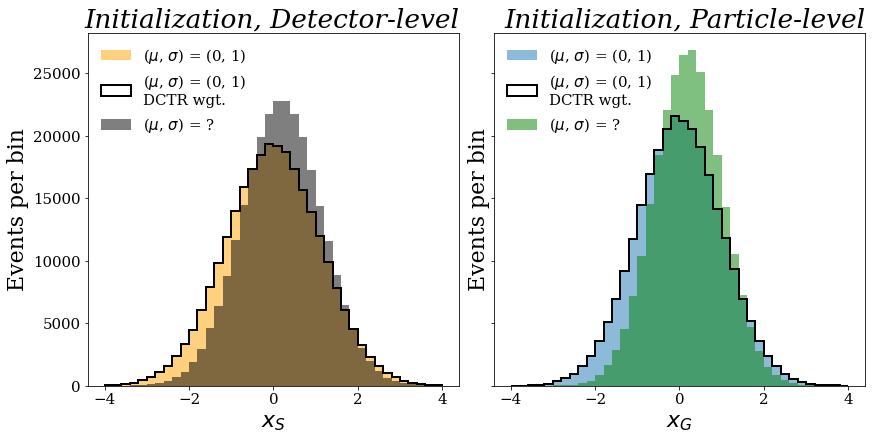

<Figure size 864x360 with 0 Axes>

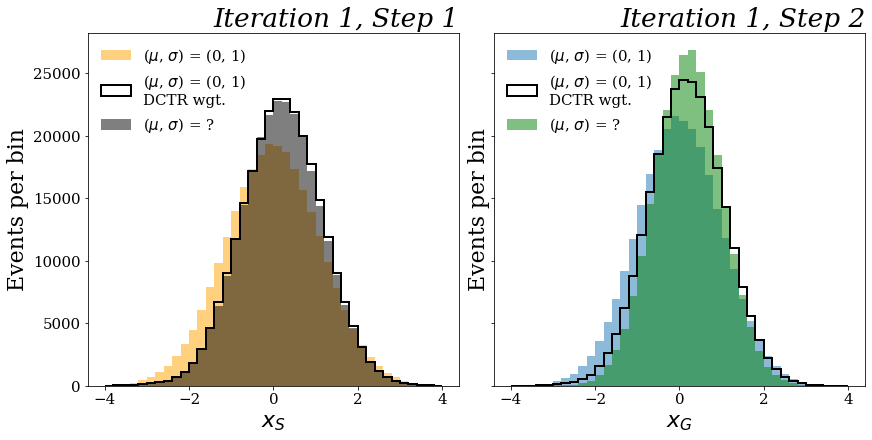

<Figure size 864x360 with 0 Axes>

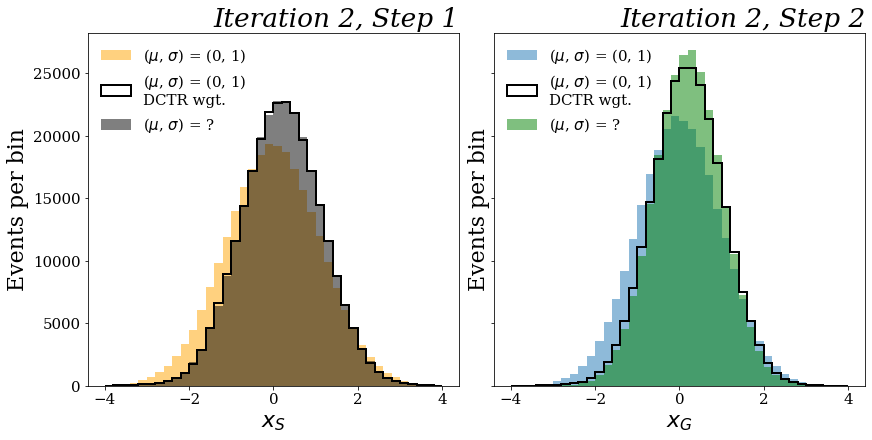

<Figure size 864x360 with 0 Axes>

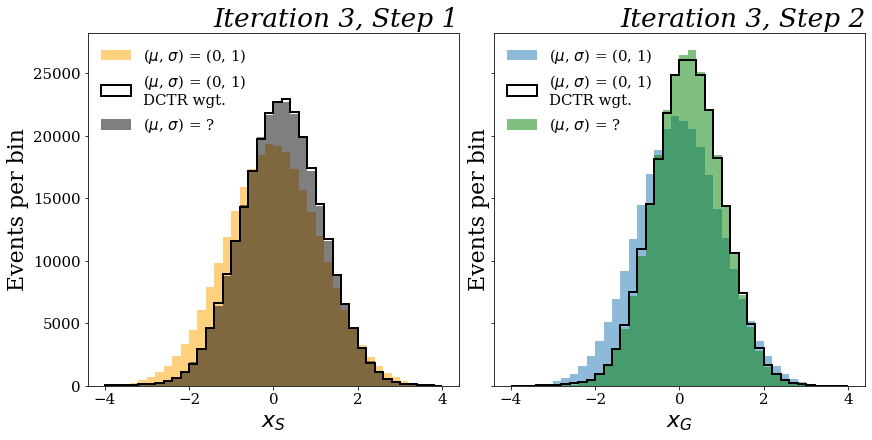

<Figure size 864x360 with 0 Axes>

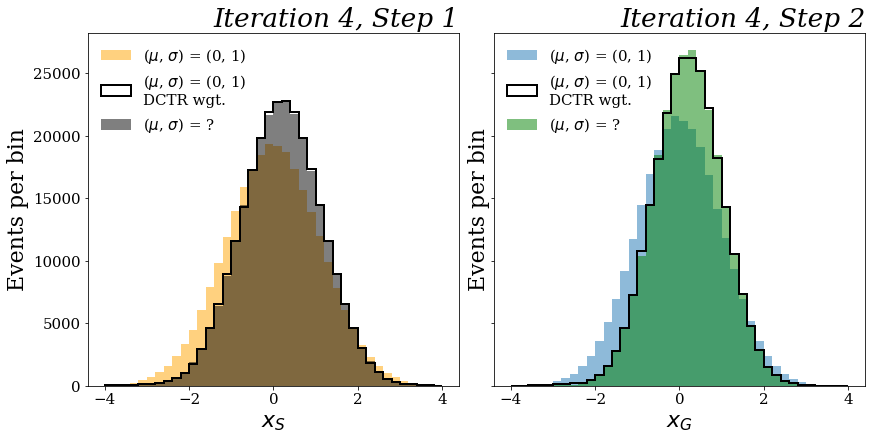

In [51]:
bins = np.linspace(-4, 4, 41)

plt.figure(figsize=(12, 5))

fig, ax = plt.subplots(1,
                       2,
                       figsize=(12, 6),
                       constrained_layout=True,
                       sharey=True)

#Detector-level
ax[0].set_title("Initialization, Detector-level",style='italic',loc='right')
hist0 = ax[0].hist(theta0_S[theta0_S!=dummyval],
                 bins=bins,
                 color="orange",
                 label=r'($\mu$, $\sigma$) = {}'.format(theta0_param),
                 **plot_style_2)

_,_,_= ax[0].hist(
    theta0_S[theta0_S!=0],
    bins=bins,
    label='($\mu$, $\sigma$) = {}\nDCTR wgt.'.format(theta0_param),
    **plot_style_1)
_,_,_= ax[0].hist(theta_unknown_S[theta_unknown_S!=dummyval],
                 bins=bins,
                 label=r'($\mu$, $\sigma$) = ?',
                 weights=weights[i, 0, :][theta_unknown_S!=dummyval],
                 **plot_style_2,
                color="black")
ax[0].legend(frameon=False)
ax[0].set_xlabel(r"$x_S$")
ax[0].set_ylabel("Events per bin")

#Particle-level
ax[1].set_title("Initialization, Particle-level",style='italic',loc='right')
_,_,_=ax[1].hist(theta0_G[theta0_G!=dummyval],
                 bins=bins,
                 label=r'($\mu$, $\sigma$) = {}'.format(theta0_param),
                 **plot_style_2)

_,_,_= ax[1].hist(
    theta0_G[theta0_G!=0],
    bins=bins,
    label='($\mu$, $\sigma$) = {}\nDCTR wgt.'.format(theta0_param),
    **plot_style_1)
_,_,_= ax[1].hist(theta_unknown_G[theta_unknown_G!=dummyval],
                 bins=bins,
                 label=r'($\mu$, $\sigma$) = ?',
                 **plot_style_2,
                color="green")
ax[1].legend(frameon=False)
ax[1].set_xlabel(r"$x_G$")
ax[1].set_ylabel("Events per bin")

plt.savefig("plot_0.pdf")

#Iterations
for i in range(iterations):
    print("ITERATION {}:".format(i + 1))
    plt.figure(figsize=(12, 5))
    
    fig, ax = plt.subplots(1,2,
                       figsize=(12, 6),
                       constrained_layout=True,
                       sharey=True)
    
    #Detector-level
    ax[0].set_title("Iteration " +str(i+1)+ ", Step 1",style='italic',loc='right')
    _,_,_ = ax[0].hist(theta0_S[theta0_S!=dummyval],
                     bins=bins,
                     label=r'($\mu$, $\sigma$) = {}'.format(theta0_param),
                     color="orange",
                     **plot_style_2)

    _,_,_ = ax[0].hist(
        theta0_S[theta0_S!=dummyval],
        bins=bins,
        label='($\mu$, $\sigma$) = {}\nDCTR wgt.'.format(theta0_param),
        weights=weights[i, 0, :][theta0_S!=dummyval],
        **plot_style_1)
    _,_,_ = ax[0].hist(theta_unknown_S[theta_unknown_S!=dummyval],
                     bins=bins,
                     label=r'($\mu$, $\sigma$) = ?',
                     **plot_style_2,
                    color="black")
    ax[0].legend(frameon=False)
    ax[0].set_xlabel(r"$x_S$")
    ax[0].set_ylabel("Events per bin")
    
    #Particle-level
    ax[1].set_title("Iteration " +str(i+1)+ ", Step 2",style='italic',loc='right')
    _,_,_ = ax[1].hist(theta0_G[theta0_G!=dummyval],
                     bins=bins,
                     label=r'($\mu$, $\sigma$) = {}'.format(theta0_param),
                     **plot_style_2)

    _,_,_ = ax[1].hist(
        theta0_G[theta0_G!=dummyval],
        bins=bins,
        label='($\mu$, $\sigma$) = {}\nDCTR wgt.'.format(theta0_param),
        weights=weights[i, 1, :][theta0_G!=dummyval],
        **plot_style_1)
    _,_,_ = ax[1].hist(theta_unknown_G[theta_unknown_G!=dummyval],
                     bins=bins,
                     label=r'($\mu$, $\sigma$) = ?',
                     **plot_style_2,
                    color="green")
    ax[1].legend(frameon=False)
    ax[1].set_xlabel(r"$x_G$")
    ax[1].set_ylabel("Events per bin")
    
    plt.savefig("plot_"+str(i+1)+".pdf")

## Owen: inspecting a few things after running everything

In [52]:
weights

array([[[1.26302493, 0.68942249, 0.91003388, ..., 0.82482851,
         0.7442798 , 1.28309679],
        [1.19787371, 0.68660122, 0.96114415, ..., 1.13145375,
         0.82314283, 1.17515135]],

       [[1.28547335, 0.60207897, 0.91585159, ..., 1.04813313,
         0.73814344, 1.24003506],
        [1.25724721, 0.5789358 , 0.92623919, ..., 1.16690803,
         0.75935489, 1.22664058]],

       [[1.31395257, 0.55902416, 0.90590096, ..., 1.14583492,
         0.73745638, 1.28175342],
        [1.29659116, 0.54324496, 0.9233129 , ..., 1.19657767,
         0.74606729, 1.25662816]],

       [[1.32559693, 0.54037428, 0.90389895, ..., 1.1905216 ,
         0.74230903, 1.28064466],
        [1.30343747, 0.51901764, 0.92041516, ..., 1.20468819,
         0.73344392, 1.26198304]]])

In [53]:
weights.shape

(4, 2, 300000)

In [54]:
Input

<function keras.engine.input_layer.Input(shape=None, batch_size=None, name=None, dtype=None, sparse=None, tensor=None, ragged=None, type_spec=None, **kwargs)>

In [55]:
Model

keras.engine.training.Model

In [56]:
x_data_and_MCback

array([-0.29655234,  1.38131165, -1.60419856, ..., -2.39860894,
        4.55716531, -6.47308044])

In [57]:
x_data_and_MCback.shape

(720222,)

In [58]:
y_data_and_MCback

array([1., 1., 1., ..., 0., 0., 0.])

In [59]:
y_data_and_MCback.shape

(720222,)

In [60]:
W_data_and_MCback

array([-1., -1., -1., ...,  1.,  1.,  1.])

In [61]:
W_data_and_MCback.shape

(720222,)

In [62]:
w_data

array([0.9097563 , 0.49690163, 0.9155347 , ..., 0.281819  , 0.01005685,
       0.00253918], dtype=float32)

In [63]:
w_data.shape

(330111,)

In [64]:
theta_unknown_S_withback[theta_unknown_S_withback!=dummyval]

array([-0.61452295, -1.98001228, -0.40134506, ..., -2.39860894,
        4.55716531, -6.47308044])

In [65]:
theta_unknown_S_withback[theta_unknown_S_withback!=dummyval].shape

(330111,)

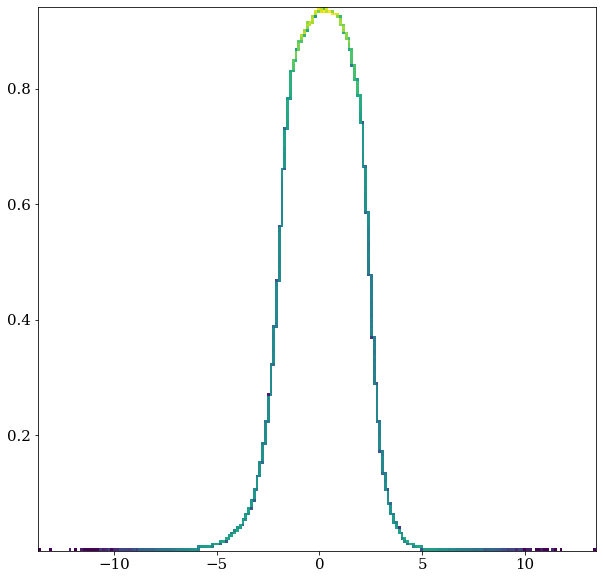

In [66]:
fig,ax = plt.subplots(1,1,figsize=(10,10))

ax.hist2d(theta_unknown_S_withback[theta_unknown_S_withback!=dummyval],
         w_data,
         density=True,
         bins=200,
         norm=mpl.colors.LogNorm())

plt.show()

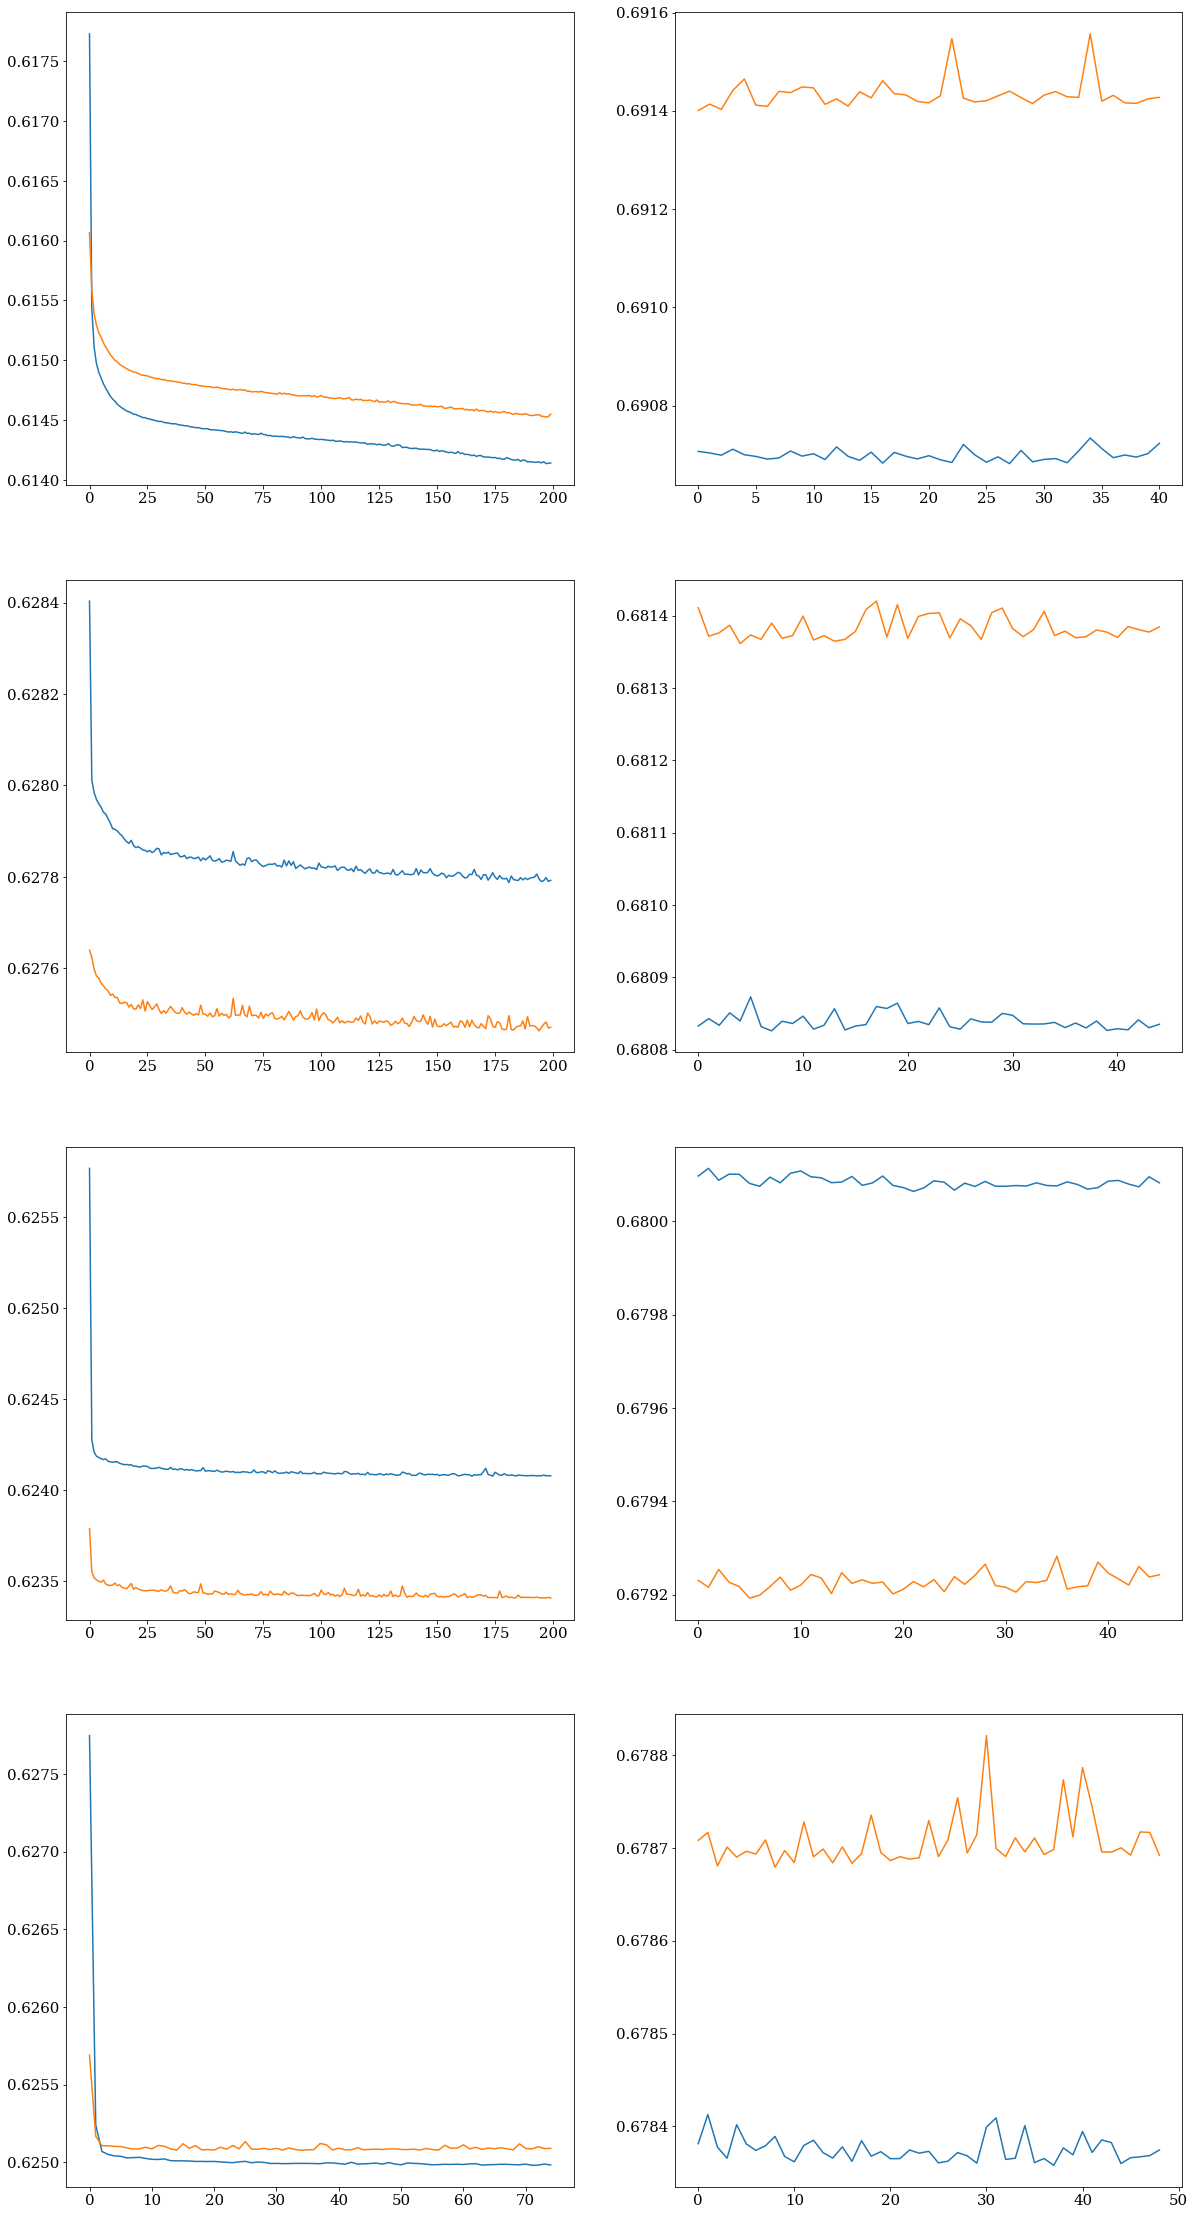

In [67]:
fig,ax = plt.subplots(4,2,figsize=(20,40))

for i in range(0,4):
    
    ax[i][0].plot( of_training_history[i][0][of_training_history[i][0]>0] )
    ax[i][0].plot( of_training_history_val[i][0][of_training_history[i][0]>0] )
    
    ax[i][1].plot( of_training_history[i][1][of_training_history[i][1]>0] )
    ax[i][1].plot( of_training_history_val[i][1][of_training_history[i][1]>0] )    
    
plt.show()

## distributions of weights

### Weights on full simulation to match data (step1)

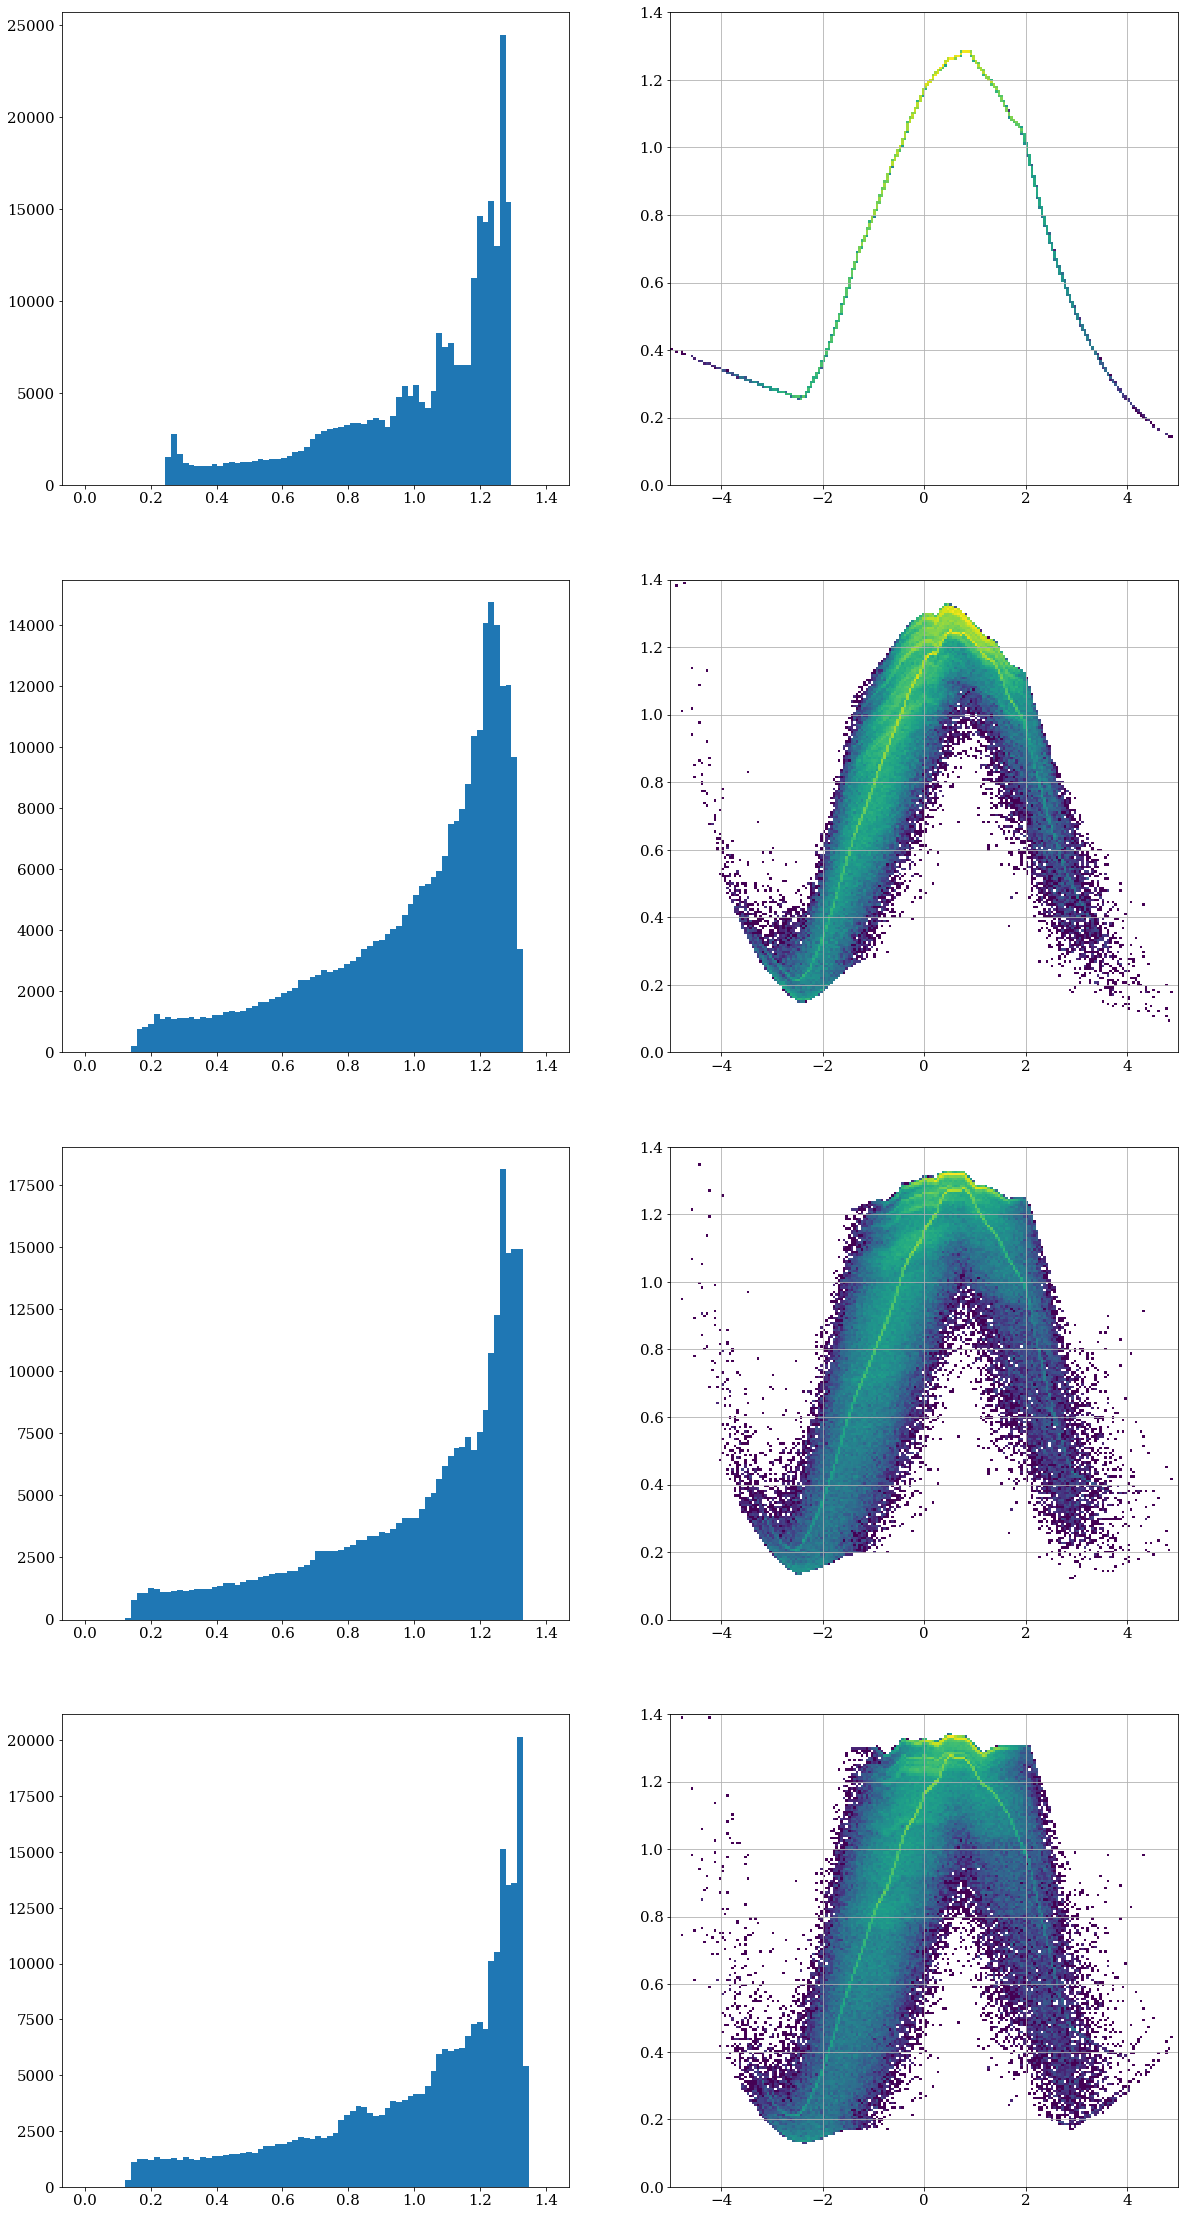

In [68]:
fig,ax = plt.subplots(iterations,2,figsize=(20,40))

for i in range(0,iterations):
    
    ax[i][0].hist( weights[i,0,theta0_S!=dummyval], bins=80, range=[0,1.4] )
    
    ax[i][1].hist2d( theta0_S[theta0_S!=dummyval], weights[i,0,theta0_S!=dummyval], 
                    bins=200, norm=mpl.colors.LogNorm(),
                   range=([-5,5],[0,1.4]))
    ax[i][1].grid()
    
plt.show()

### Weights on gen (step2)

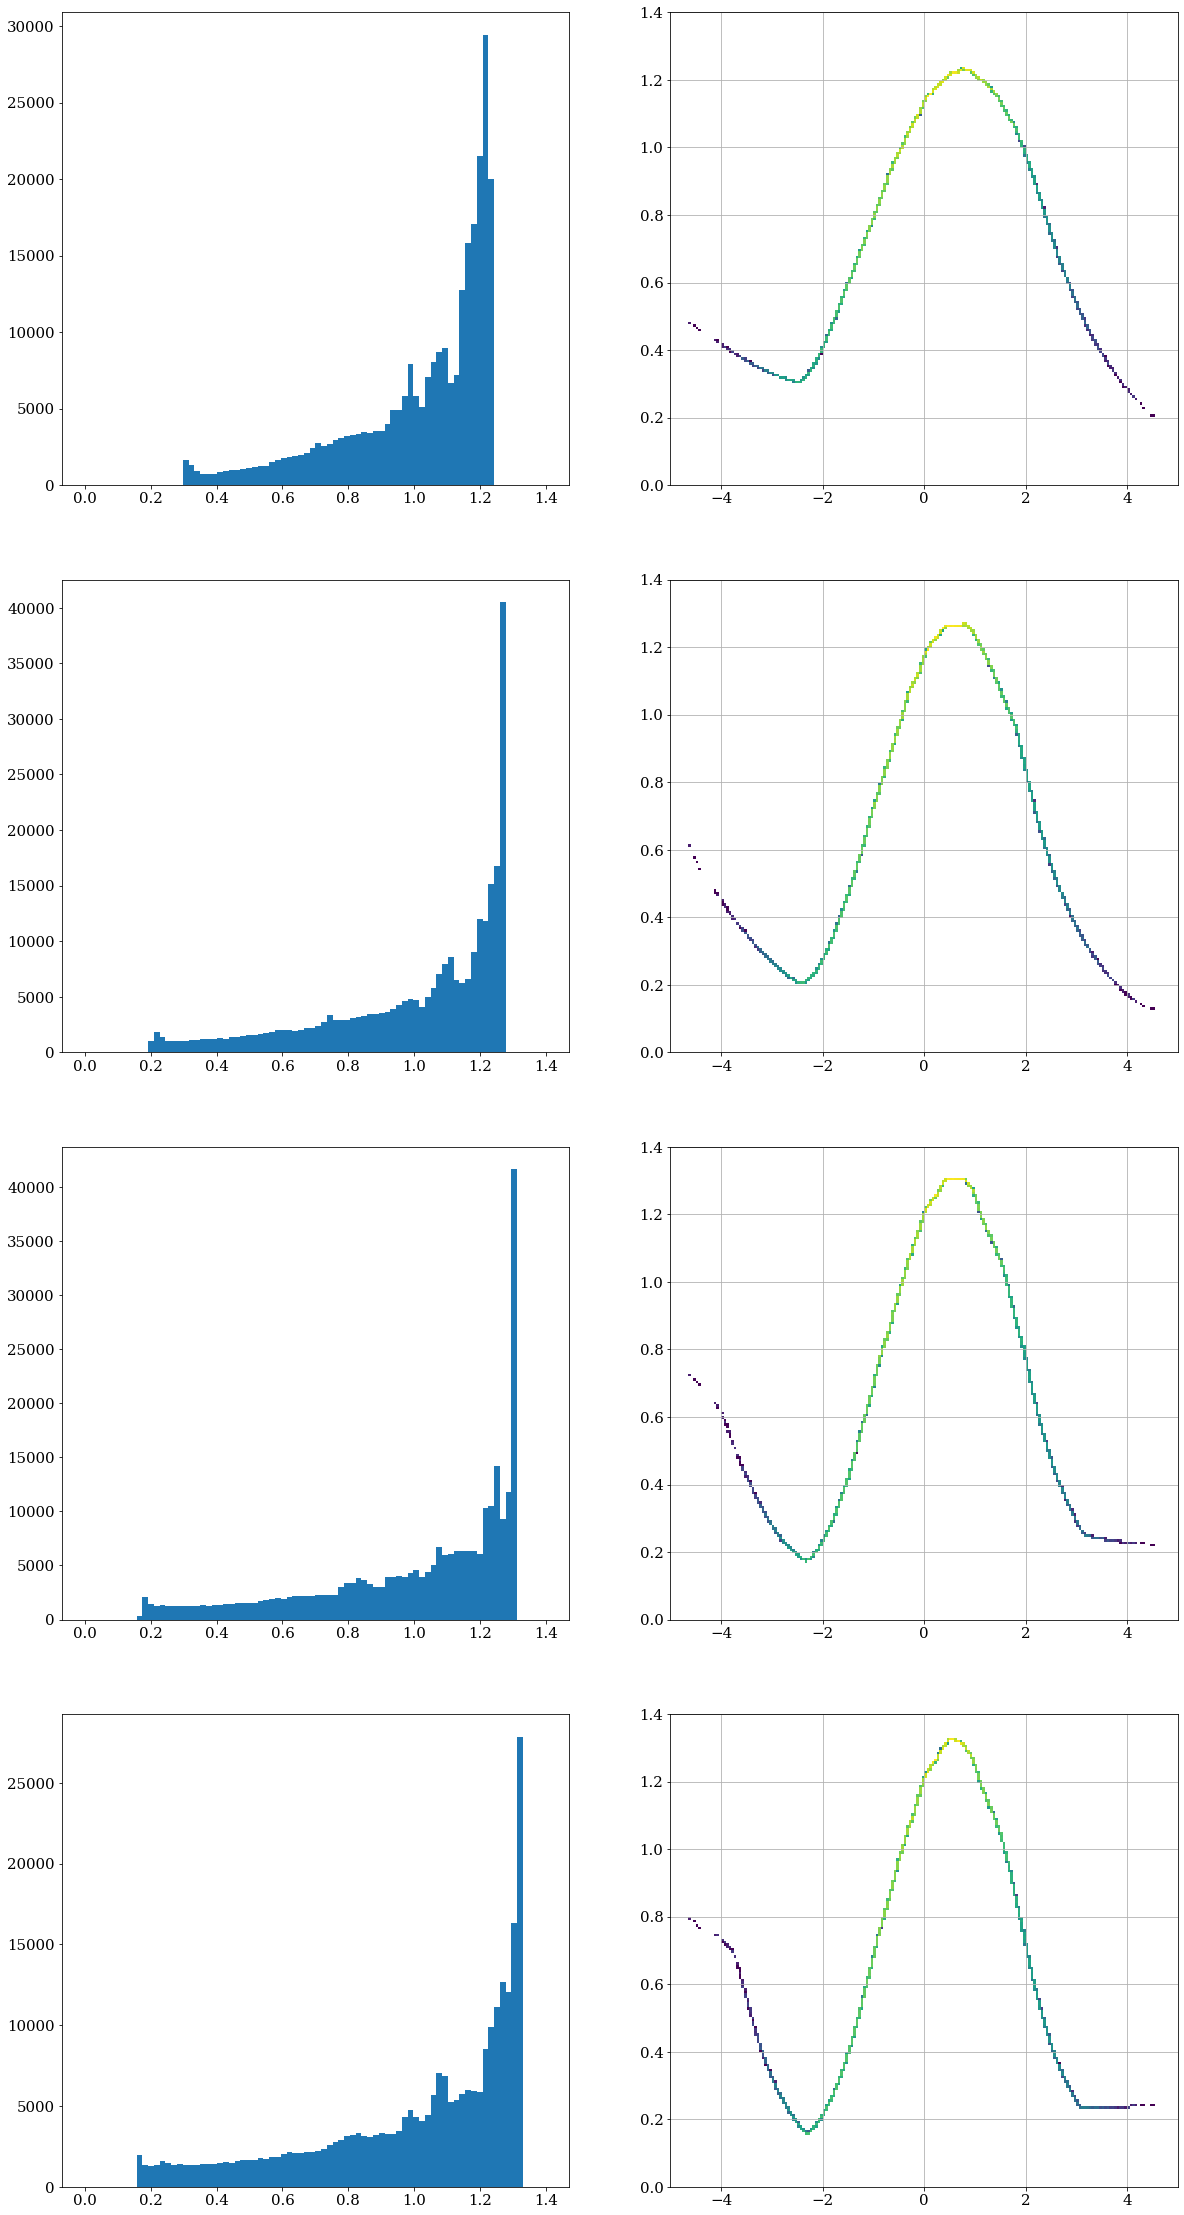

In [69]:
fig,ax = plt.subplots(iterations,2,figsize=(20,40))

for i in range(0,iterations):
    
    ax[i][0].hist( weights[i,1,theta0_G!=dummyval], bins=80, range=[0,1.4] )
    
    ax[i][1].hist2d( theta0_G[theta0_G!=dummyval], weights[i,1,theta0_G!=dummyval], 
                    bins=200, norm=mpl.colors.LogNorm(),
                   range=([-5,5],[0,1.4]))
    ax[i][1].grid()
    
plt.show()

## Change in weights on fullsim (step1) between consecutive iterations

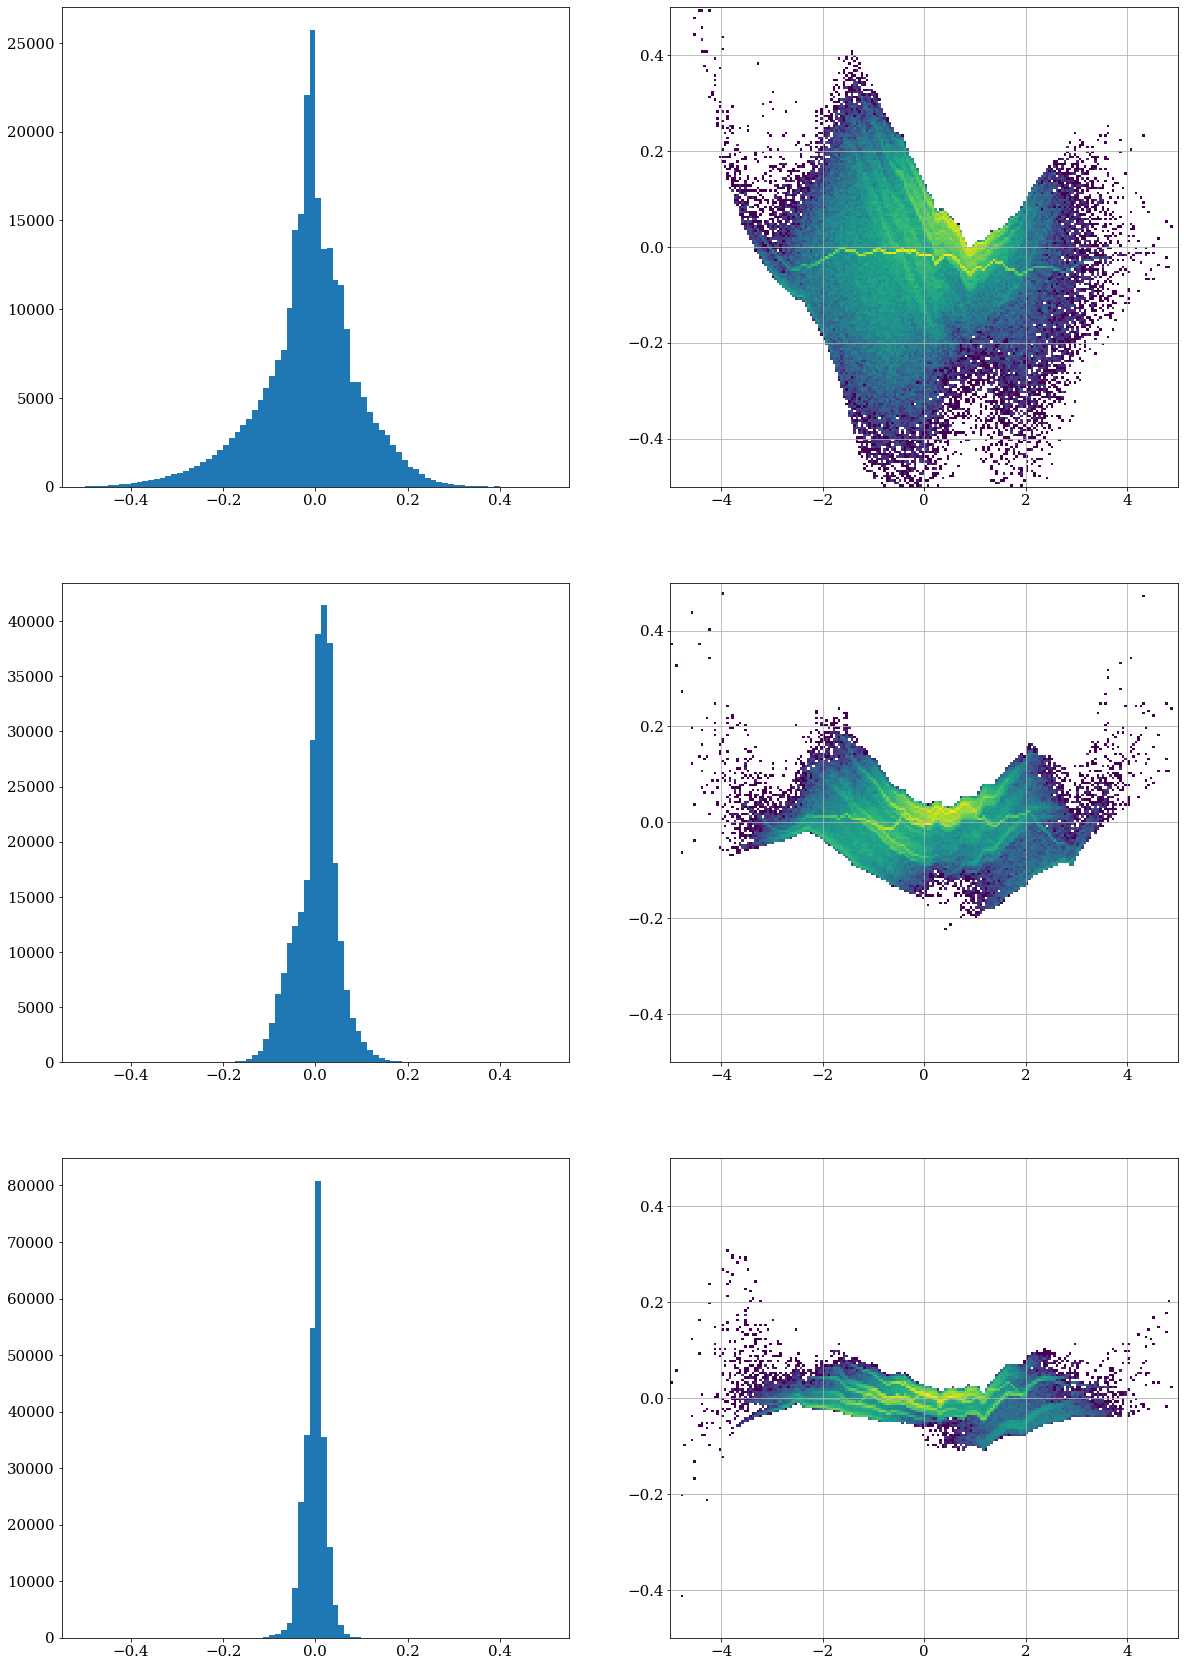

In [70]:
fig,ax = plt.subplots(iterations-1,2,figsize=(20,30))

for i in range(0,iterations-1):
    
    ax[i][0].hist( weights[i+1,0,theta0_S!=dummyval]-weights[i,0,theta0_S!=dummyval], bins=80,
                 range=[-0.5,0.5])
    
    ax[i][1].hist2d( theta0_S[theta0_S!=dummyval], weights[i+1,0,theta0_S!=dummyval]-weights[i,0,theta0_S!=dummyval], 
                    bins=200, norm=mpl.colors.LogNorm(),
                   range=([-5,5],[-0.5,0.5]))
    ax[i][1].grid()
    
plt.show()

## Change in weights on gen (step2) between consecutive iterations

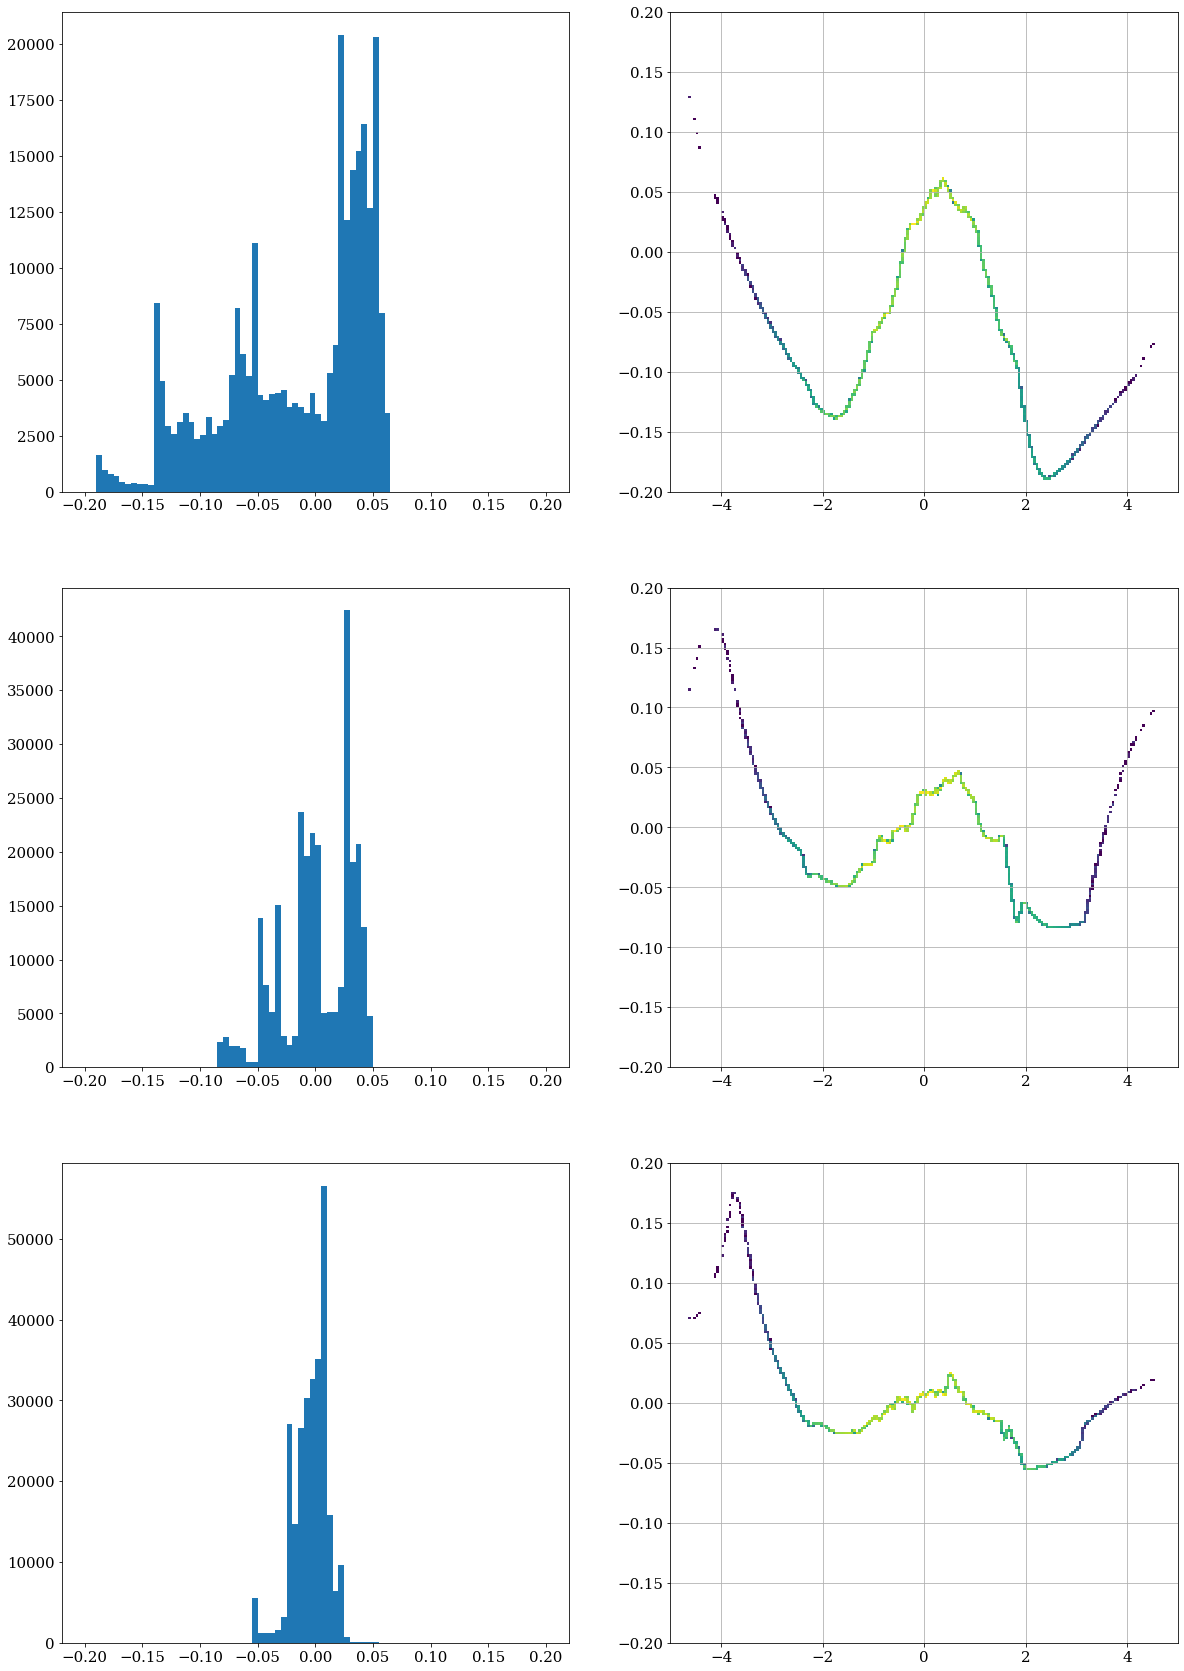

In [71]:
fig,ax = plt.subplots(iterations-1,2,figsize=(20,30))

for i in range(0,iterations-1):
    
    ax[i][0].hist( weights[i+1,1,theta0_G!=dummyval]-weights[i,1,theta0_G!=dummyval], bins=80,
                 range=[-0.2,0.2])
    
    ax[i][1].hist2d( theta0_G[theta0_G!=dummyval], weights[i+1,1,theta0_G!=dummyval]-weights[i,1,theta0_G!=dummyval], 
                    bins=200, norm=mpl.colors.LogNorm(),
                   range=([-5,5],[-0.2,0.2]))
    ax[i][1].grid()
    
plt.show()

In [72]:
nn_output

array([[[0.55811357, 0.40808174, 0.47644907, ..., 0.4520033 ,
         0.42669749, 0.56199843],
        [0.5450148 , 0.40709162, 0.49009356, ..., 0.53083664,
         0.45149663, 0.54026186]],

       [[0.51763743, 0.46720588, 0.4879348 , ..., 0.48088616,
         0.47277907, 0.51343244],
        [0.55698252, 0.36666203, 0.48085368, ..., 0.53851295,
         0.43160984, 0.55089295]],

       [[0.51102704, 0.49125117, 0.49444959, ..., 0.49544412,
         0.49268496, 0.51098567],
        [0.56457204, 0.35201472, 0.4800638 , ..., 0.54474634,
         0.42728439, 0.55686098]],

       [[0.50553083, 0.49867541, 0.49468756, ..., 0.49873149,
         0.49873748, 0.50473273],
        [0.56586623, 0.34167978, 0.47927925, ..., 0.54642111,
         0.42311373, 0.55791003]]])

## Output of NN for step1: distinguish data from fullsim

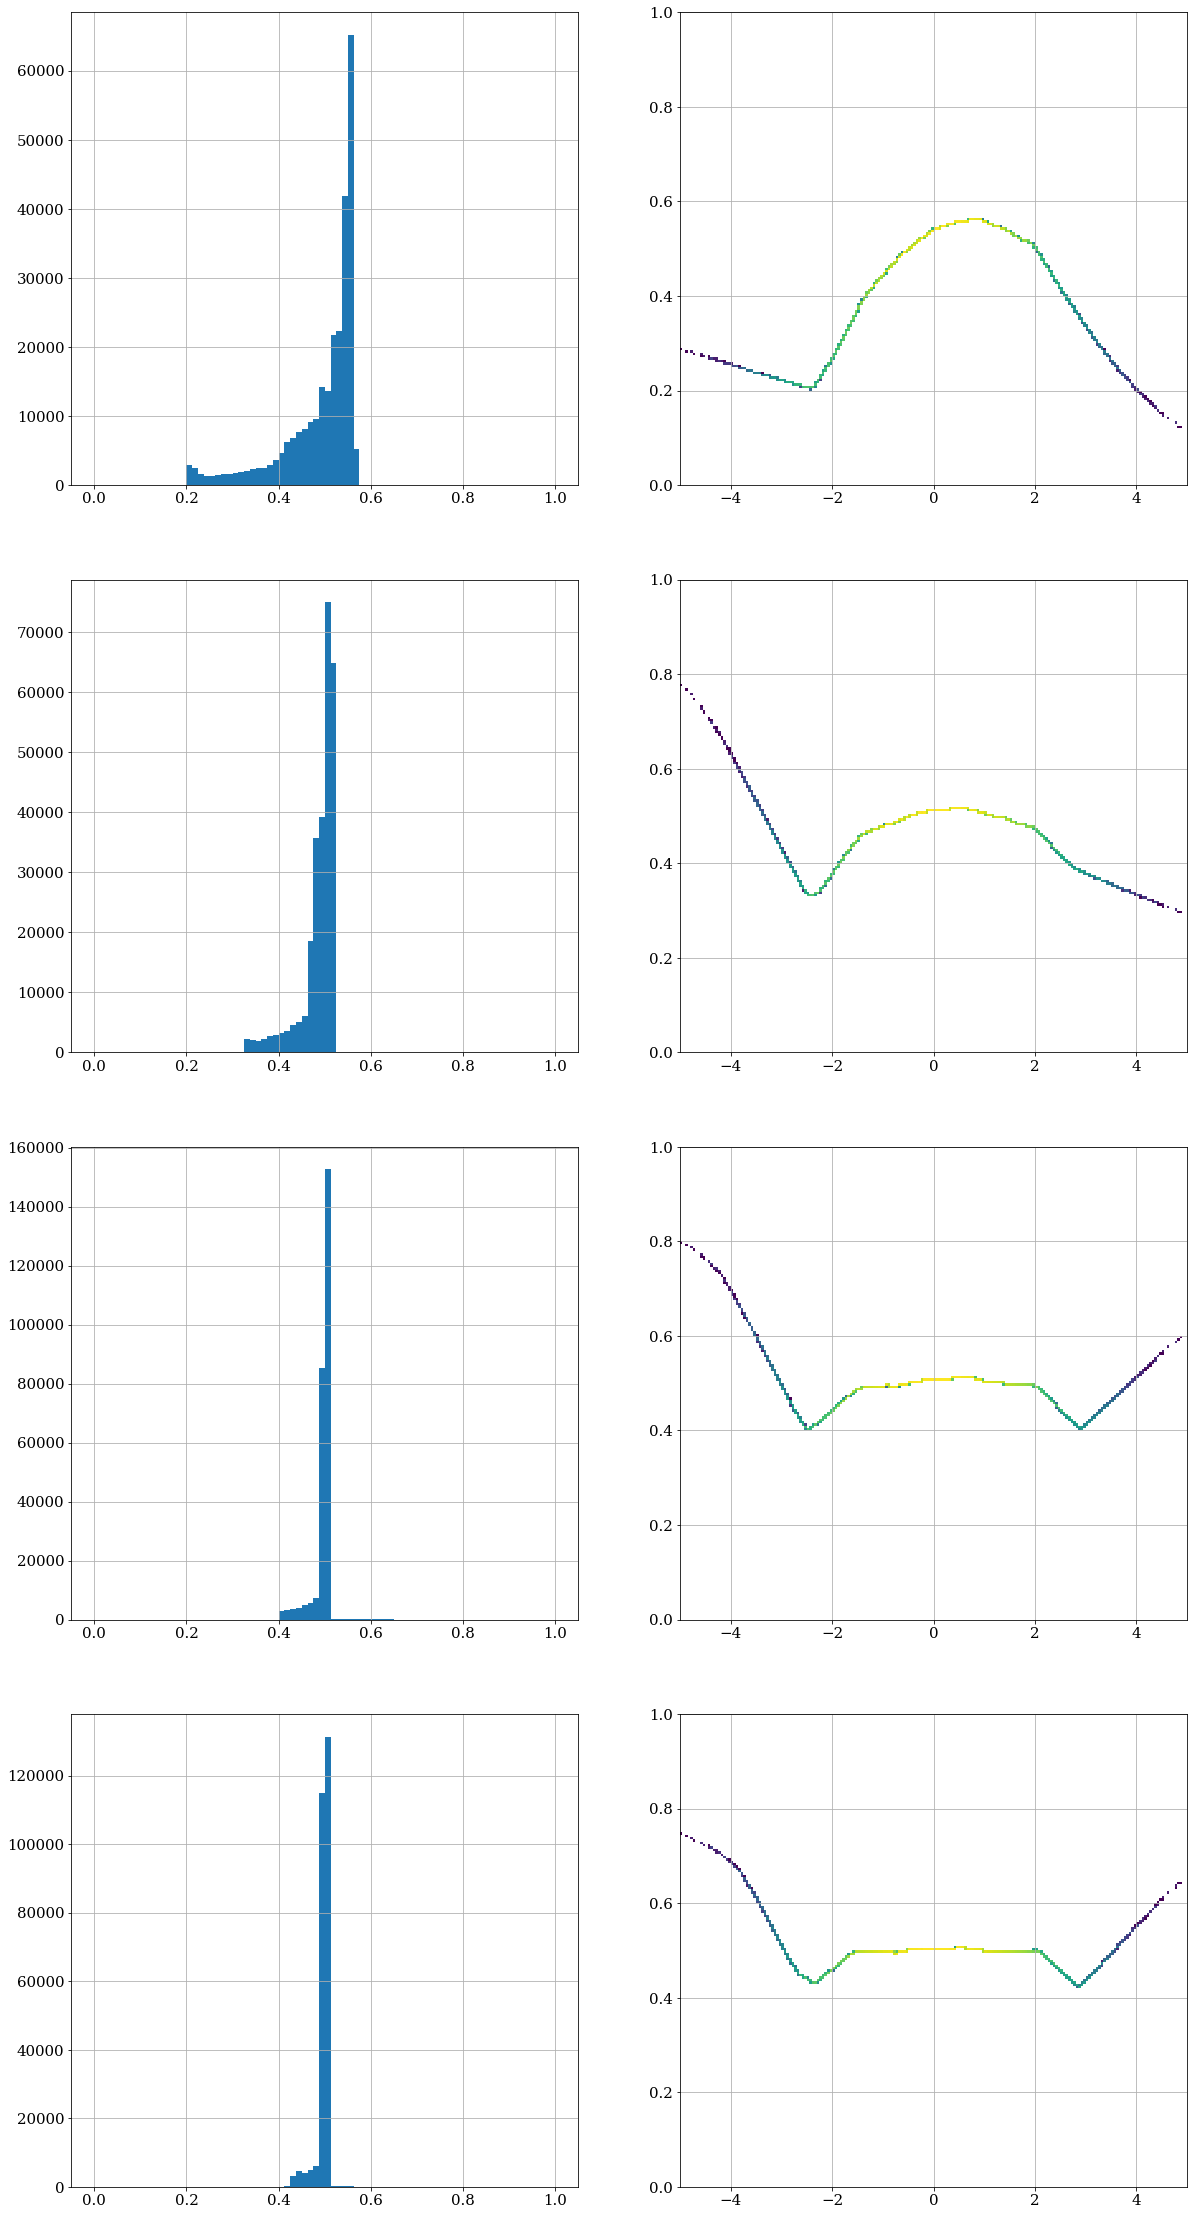

In [73]:
fig,ax = plt.subplots(iterations,2,figsize=(20,40))

for i in range(0,iterations):
    
    ax[i][0].hist( nn_output[i,0,theta0_S!=dummyval], bins=80, range=[0,1] )
    ax[i][0].grid()
    
    ax[i][1].hist2d( theta0_S[theta0_S!=dummyval], nn_output[i,0,theta0_S!=dummyval], 
                    bins=200, norm=mpl.colors.LogNorm(),
                   range=([-5,5],[0,1]))
    ax[i][1].grid()
    
plt.show()

## NN output of step2 : distinguish gen

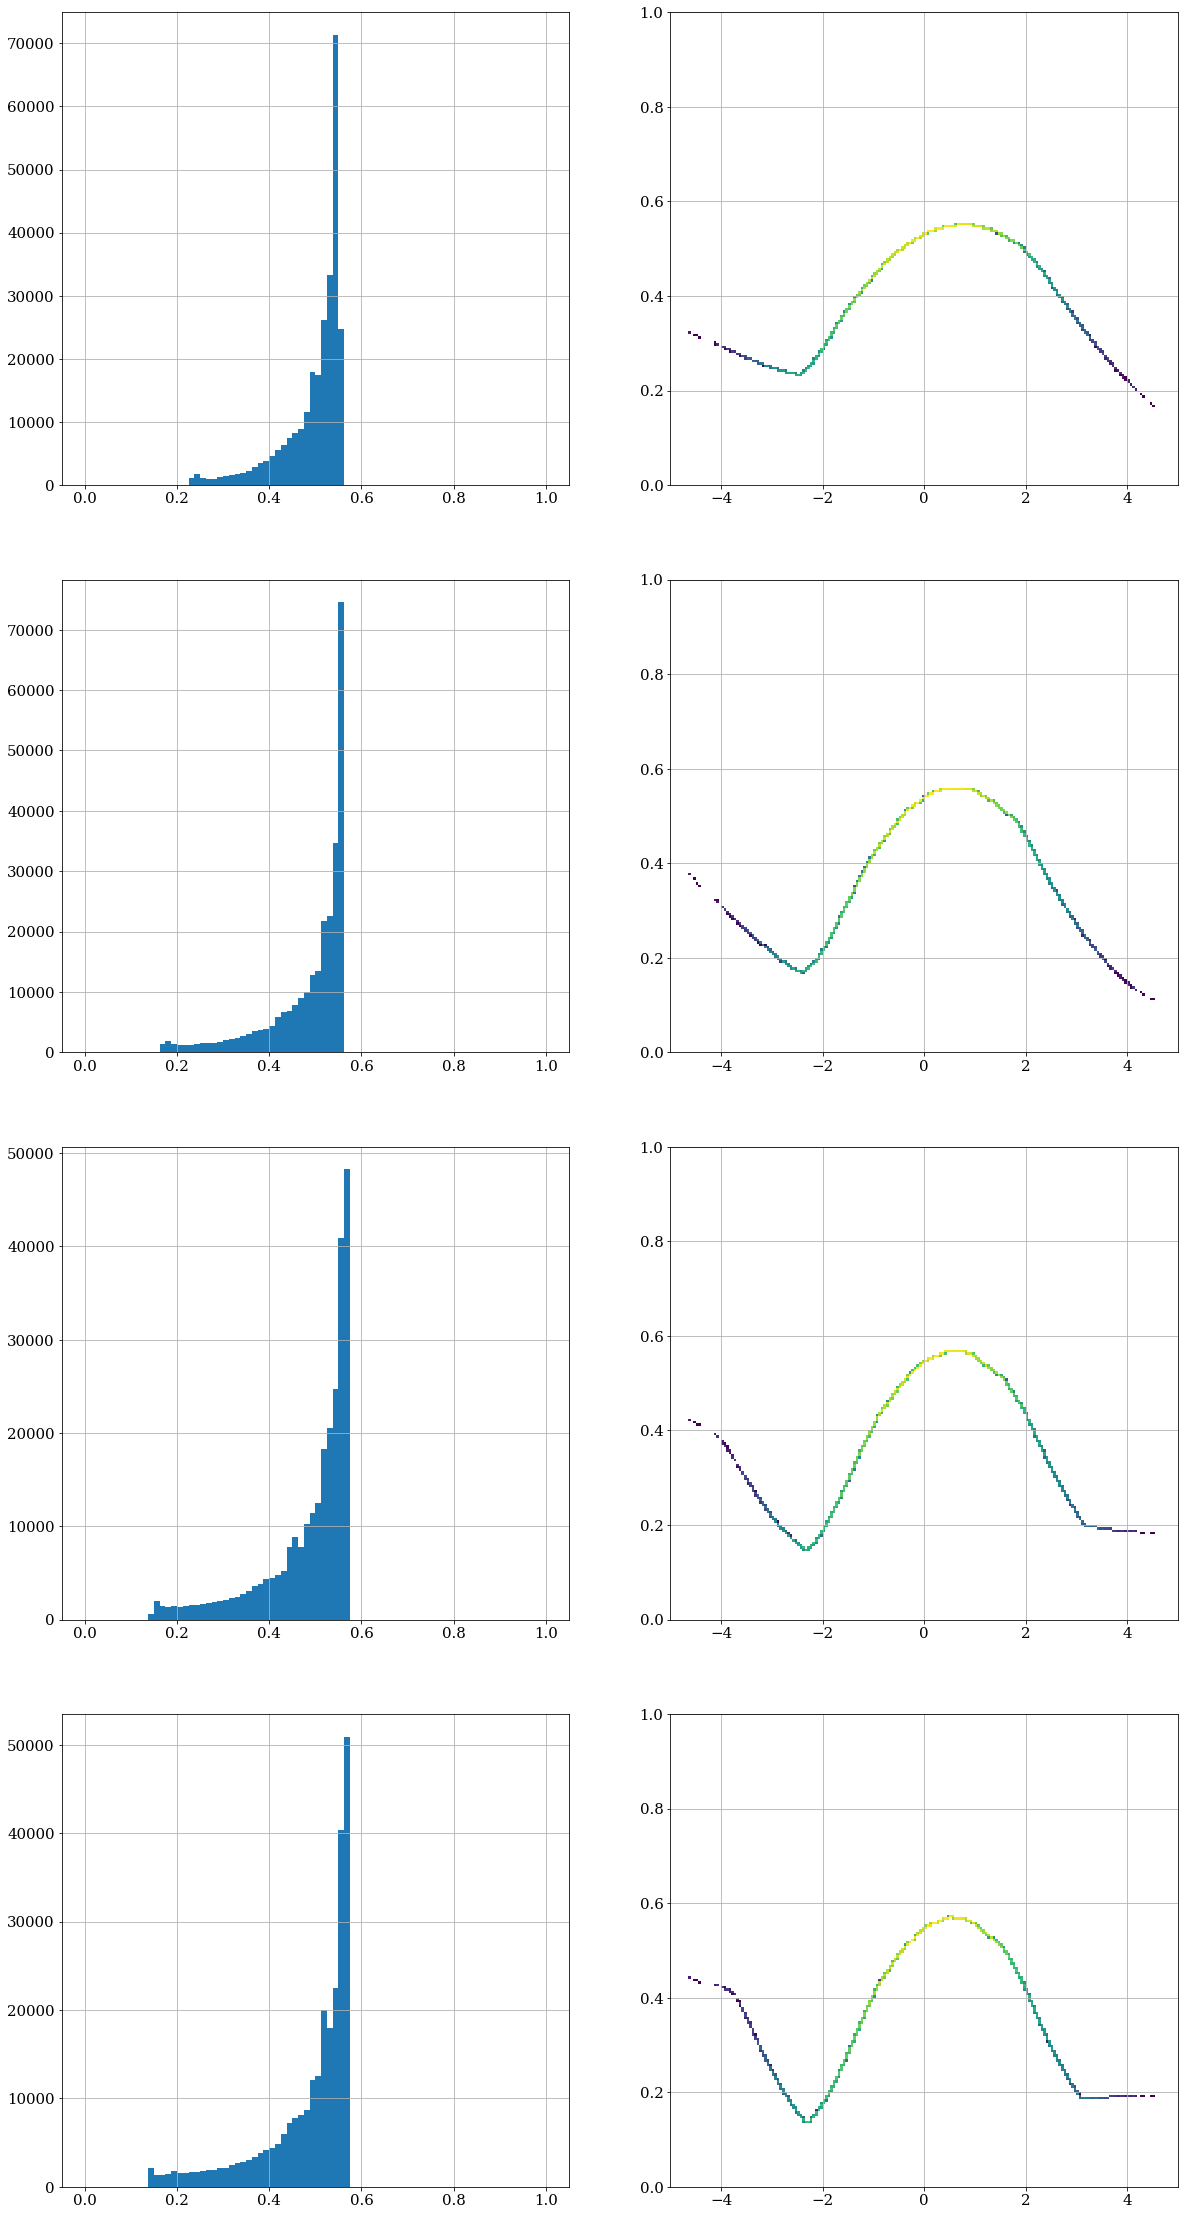

In [74]:
fig,ax = plt.subplots(iterations,2,figsize=(20,40))

for i in range(0,iterations):
    
    ax[i][0].hist( nn_output[i,1,theta0_G!=dummyval], bins=80, range=[0,1] )
    ax[i][0].grid()
    
    ax[i][1].hist2d( theta0_G[theta0_G!=dummyval], nn_output[i,1,theta0_G!=dummyval], 
                    bins=200, norm=mpl.colors.LogNorm(),
                   range=([-5,5],[0,1]))
    ax[i][1].grid()
    
plt.show()

## Understanding the step 1 weights

As shown above, the **step 1** weight after the first iteration is not a single-valued function of the sim value.  This is because the data are two dimensional, with the two dimensions being the sim value and the gen value.  

The **step 1** weight depends on both the gen and sim values, so it can be thought of as a single-valued function in the gen, sim plane.  Given a gen, sim value pair, the step 1 weight has a unique value.  This is tested and verified below by making 2D scatter plots of the weight vs the sim value in a narrow slice of the gen value.  The results are single-valued functions of the sim value, as expected.

The **step 2** weight is by construction only a function of the gen value and it comes from the step 2 NN as weight = NN(gen) / (1 - NN(gen))



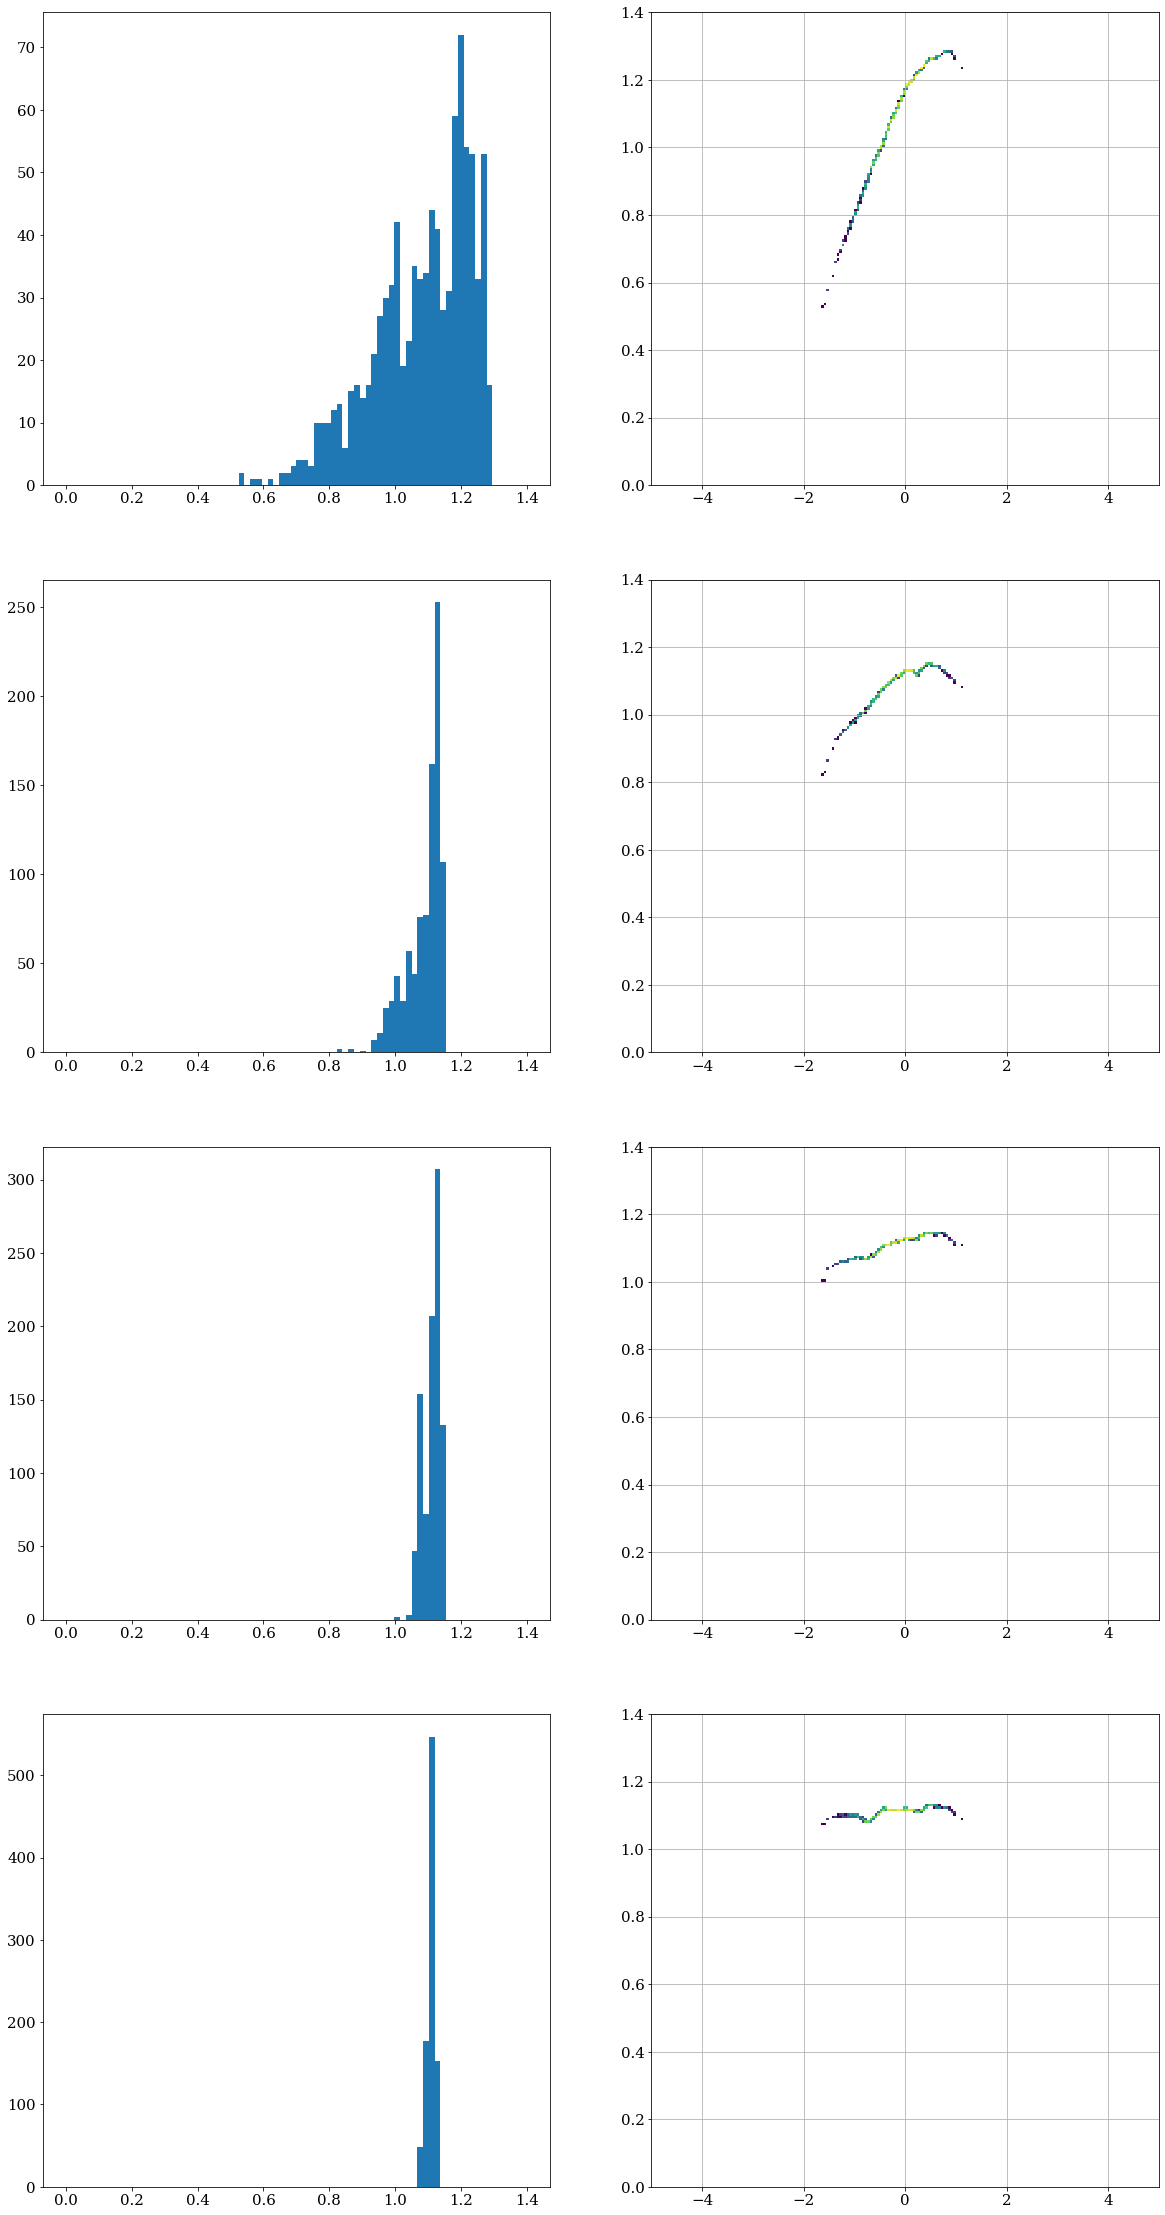

In [75]:

min_genval = -0.21
max_genval = -0.20

fig,ax = plt.subplots(iterations,2,figsize=(20,40))

for i in range(0,iterations):
    
    ax[i][0].hist( weights[i,0,(theta0_S!=dummyval)*(theta0_G>min_genval)*(theta0_G<max_genval)],
                  bins=80, range=[0,1.4] )
    
    ax[i][1].hist2d( theta0_S[(theta0_S!=dummyval)*(theta0_G>min_genval)*(theta0_G<max_genval)],
                    weights[i,0,(theta0_S!=dummyval)*(theta0_G>min_genval)*(theta0_G<max_genval)], 
                    bins=200, norm=mpl.colors.LogNorm(),
                   range=([-5,5],[0,1.4]))
    ax[i][1].grid()
    
plt.show()

## Analytical derivation of the OmniFold steps and results

For the 1D case, the NN function can be simply predicted as the probability of the class with target (y) = 1.  This can be constructed from histograms of the NN input at each stage and then compared to the NN output.  

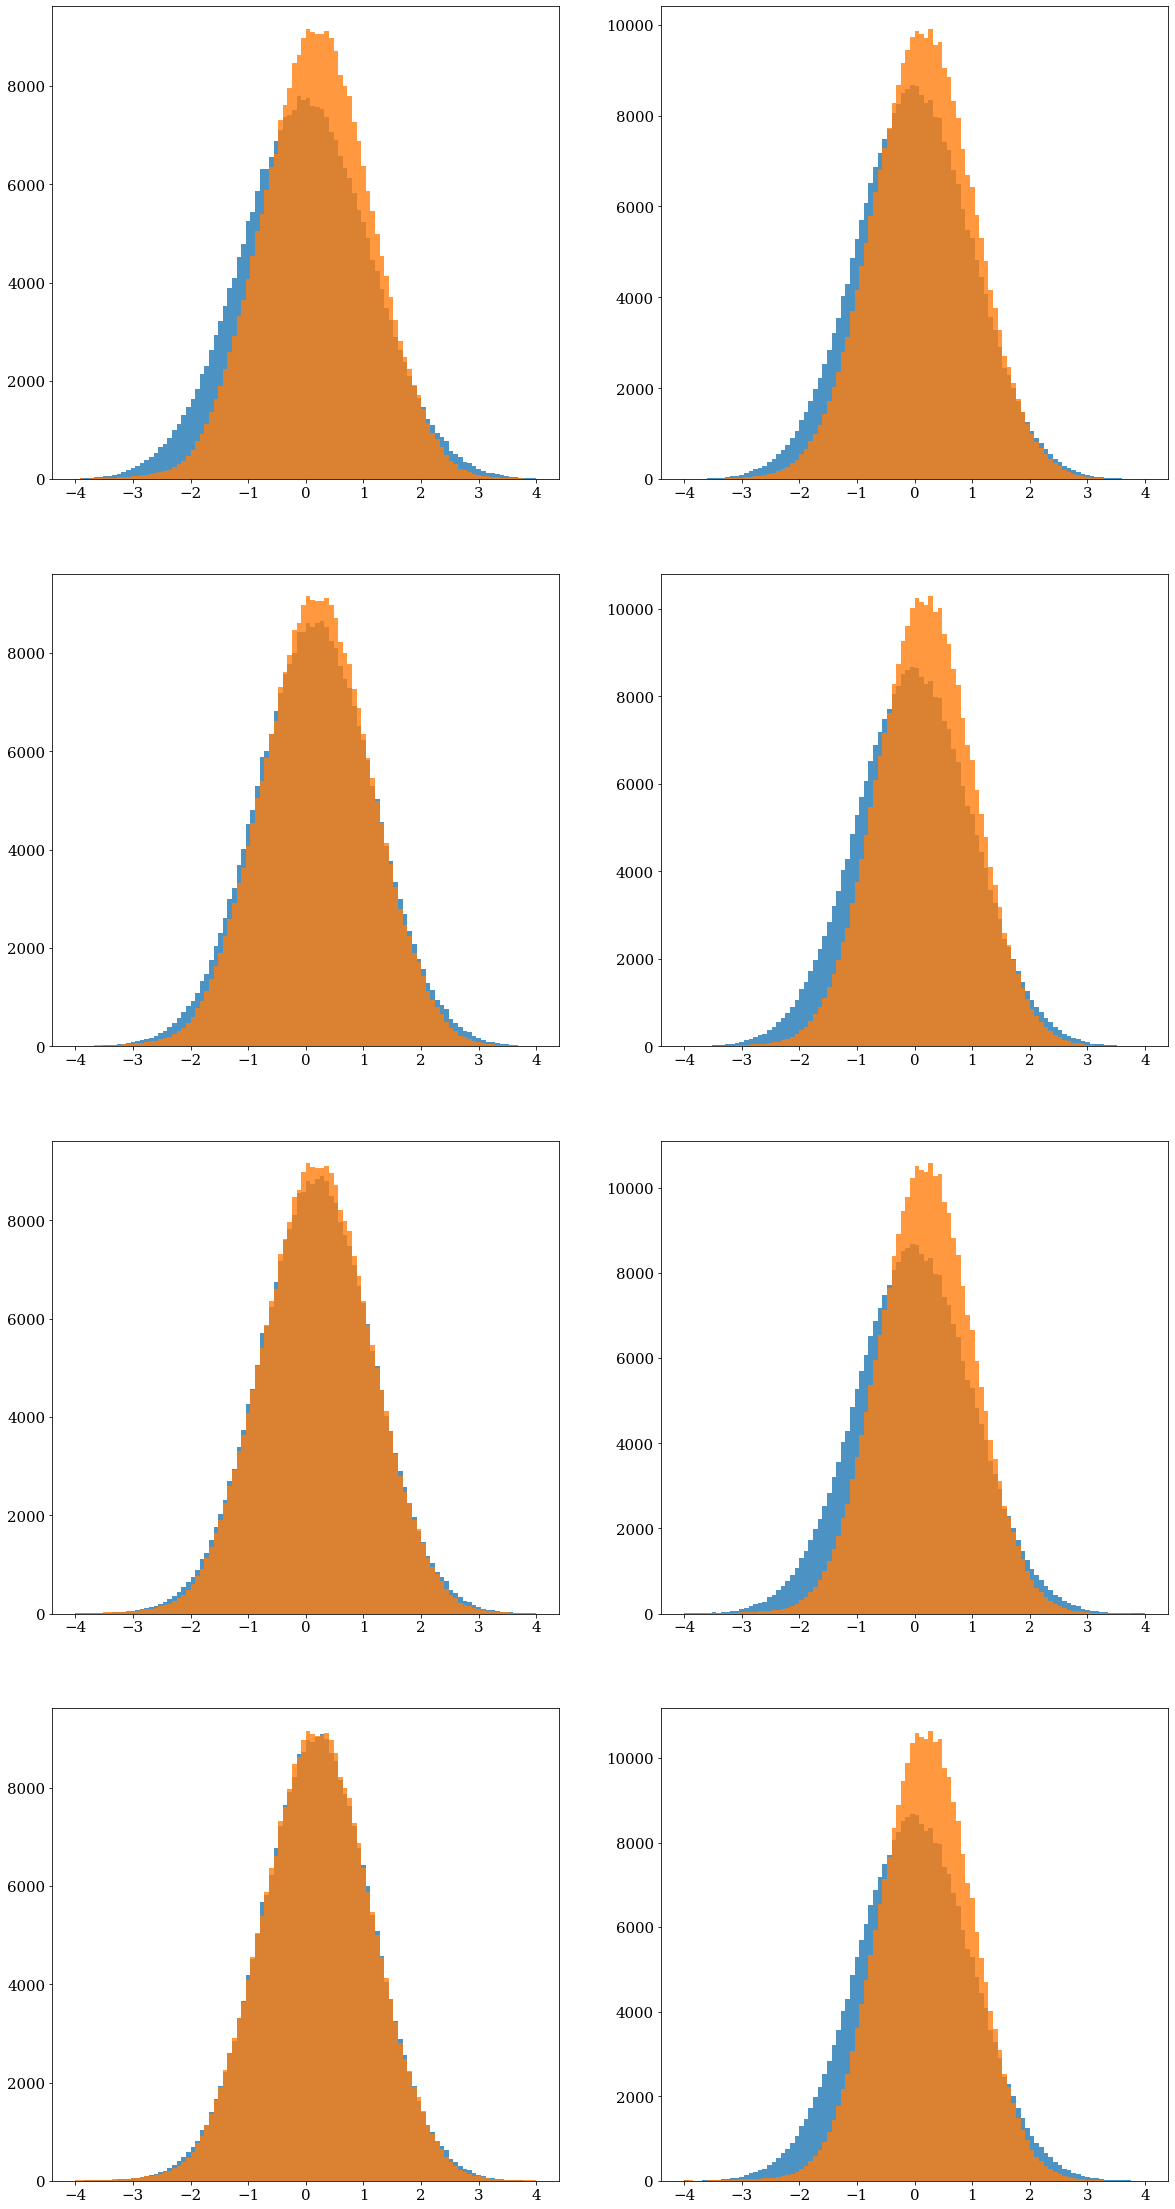

In [76]:
hist_xmin = -4
hist_xmax = 4
hist_bins = 100

hist_data_y0 = np.zeros( shape=(iterations, 2, hist_bins) )
hist_data_y1 = np.zeros( shape=(iterations, 2, hist_bins) )


fig,ax = plt.subplots(iterations,2,figsize=(20,40))

for i in range(0,iterations):
    
    
    
    this_hist_data = ax[i][0].hist( theta0_S[theta0_S!=dummyval],
                                   range=[hist_xmin,hist_xmax], 
                                   weights=input_weights_step1_y0[i,theta0_S!=dummyval],
                                   bins=hist_bins,
                                  alpha=0.8)
    hist_data_y0[i,0,:] = this_hist_data[0]
    
    this_hist_data = ax[i][0].hist( theta_unknown_S_withback[theta_unknown_S_withback!=dummyval],
                                   range=[hist_xmin,hist_xmax], 
                                   weights=input_weights_step1_y1[i,:],
                                   bins=hist_bins,
                                  alpha=0.8)
    hist_data_y1[i,0,:] = this_hist_data[0]
    

    
    
    this_hist_data = ax[i][1].hist( theta0_G,
                                   range=[hist_xmin,hist_xmax], 
                                   weights=input_weights_step2_y0[i,:],
                                   bins=hist_bins,
                                  alpha=0.8)
    hist_data_y0[i,1,:] = this_hist_data[0]    

    this_hist_data = ax[i][1].hist( theta0_G,
                                   range=[hist_xmin,hist_xmax], 
                                   weights=input_weights_step2_y1[i,:],
                                   bins=hist_bins,
                                  alpha=0.8)
    hist_data_y1[i,1,:] = this_hist_data[0]   
    
    hist_axis_data = this_hist_data[1]


In [77]:
hist_axis_centers = np.ones(hist_bins)
for i in range(0,hist_bins):
    hist_axis_centers[i] = 0.5*(hist_axis_data[i]+hist_axis_data[i+1])

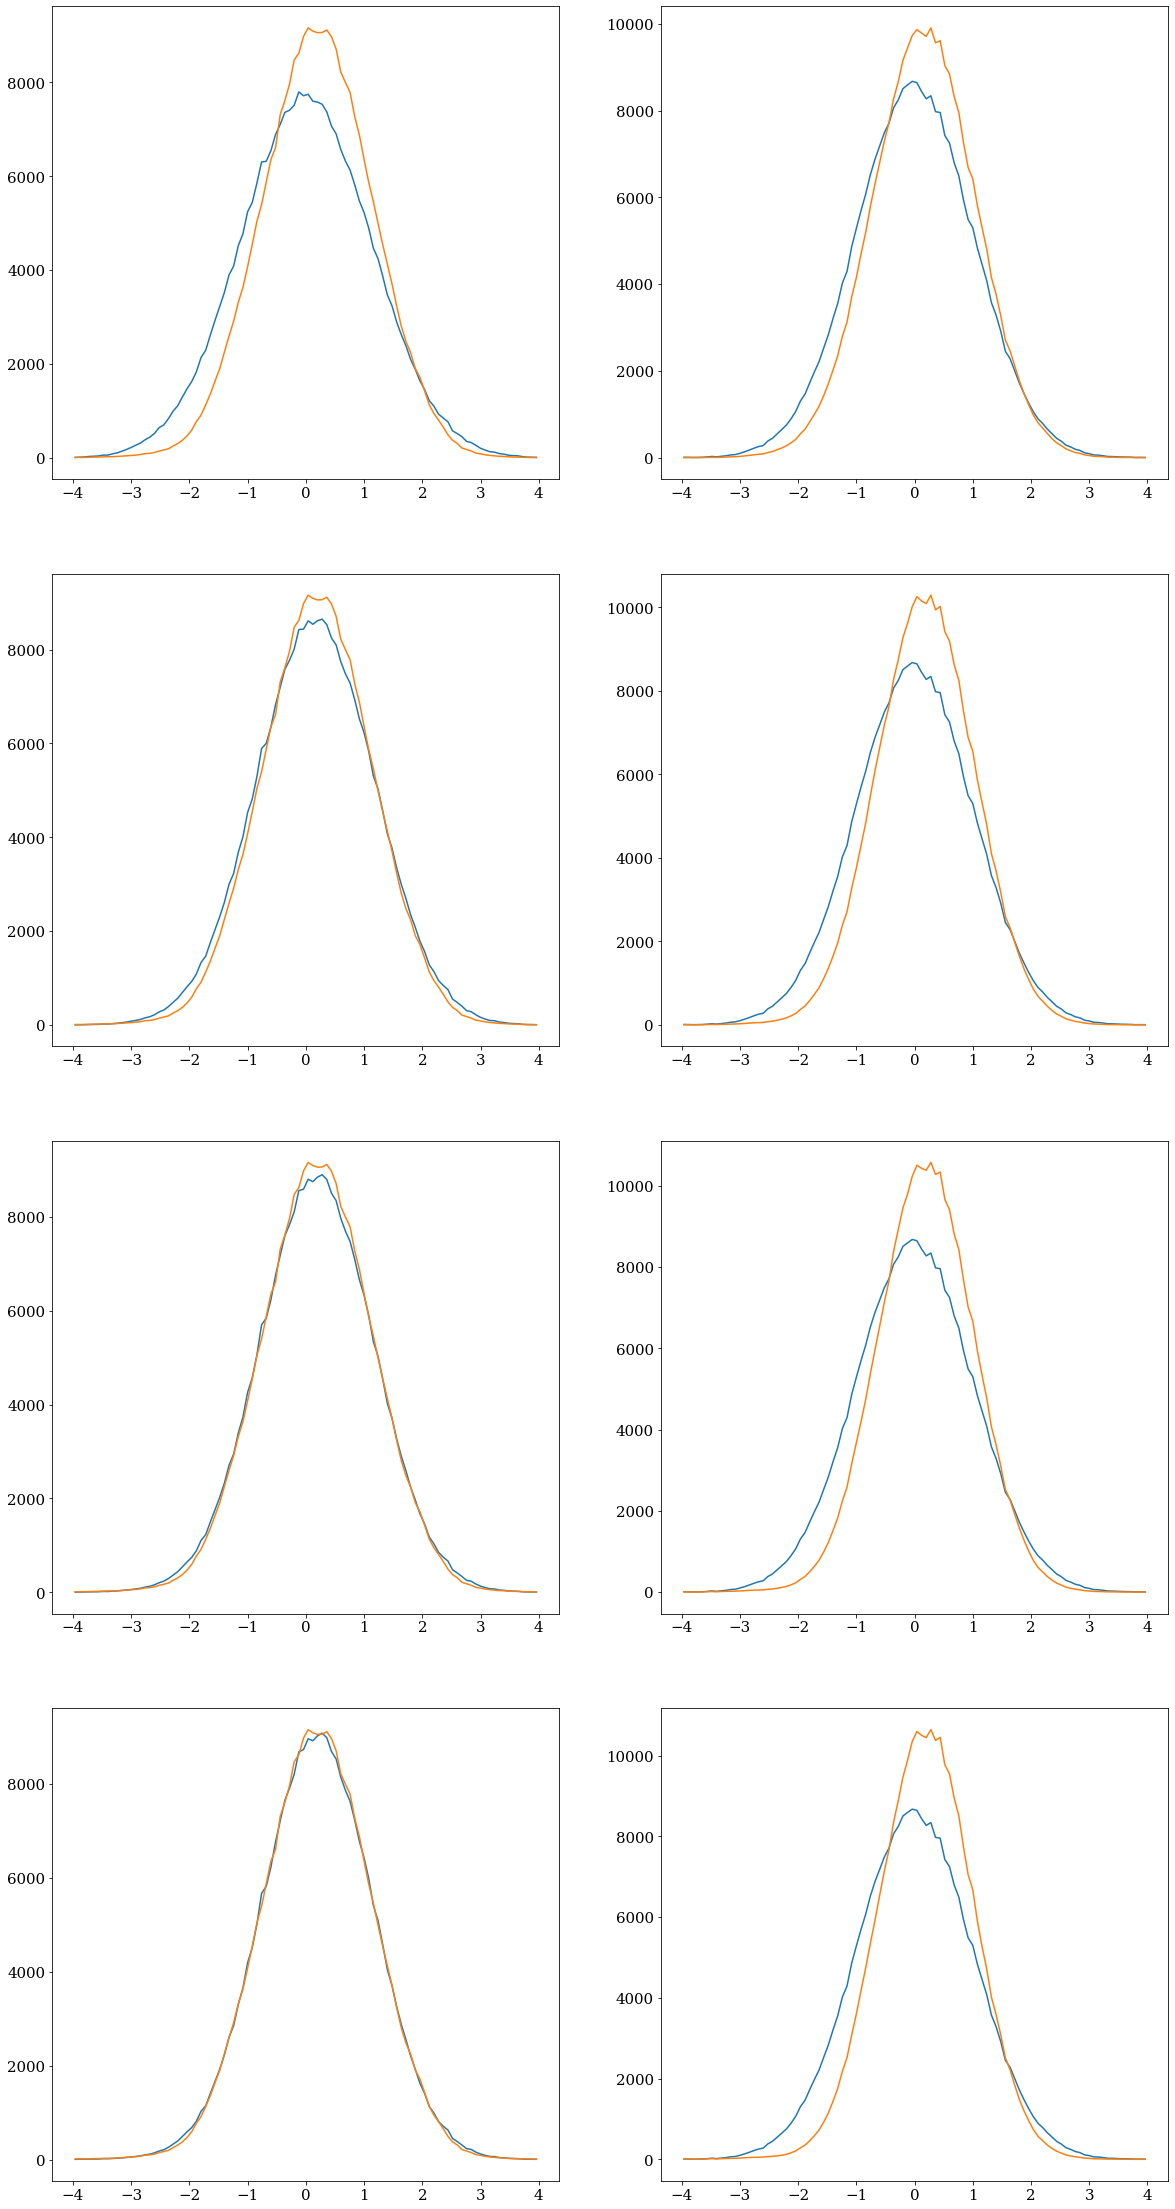

In [78]:
fig,ax = plt.subplots(iterations,2,figsize=(20,40))

for i in range(0,iterations):
 

    ax[i][0].plot( hist_axis_centers, hist_data_y0[i,0,:] )
    ax[i][0].plot( hist_axis_centers, hist_data_y1[i,0,:] )

    ax[i][1].plot( hist_axis_centers, hist_data_y0[i,1,:] )
    ax[i][1].plot( hist_axis_centers, hist_data_y1[i,1,:] )

### Predict NN output from histograms

In [80]:
pred_nn_output = (hist_data_y1)/(hist_data_y0+hist_data_y1)


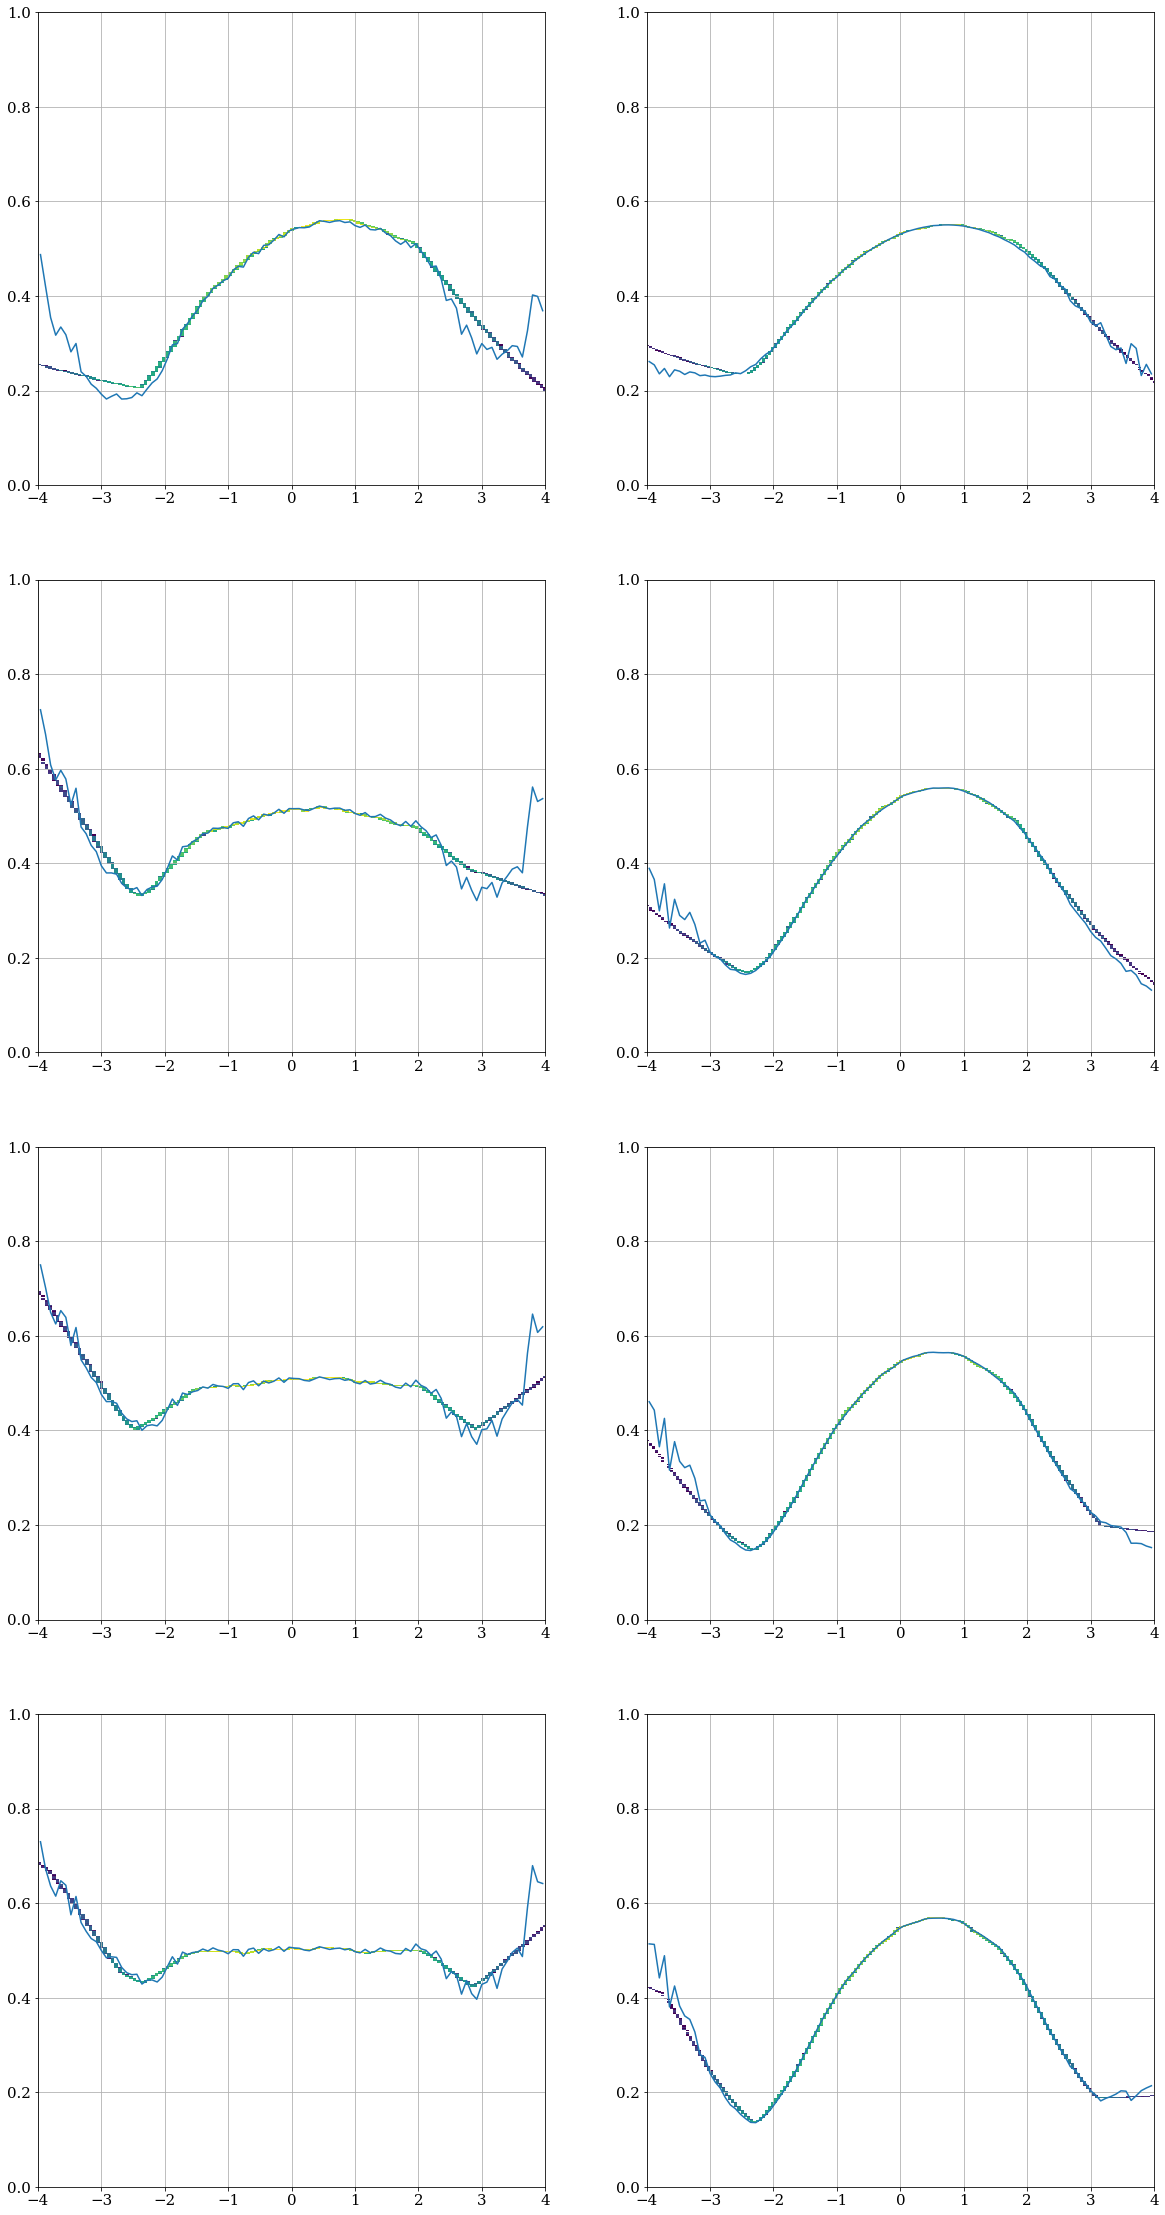

In [89]:
fig,ax = plt.subplots(iterations,2,figsize=(20,40))

for i in range(0,iterations):
 

    ax[i][0].plot( hist_axis_centers, pred_nn_output[i,0,:] )
    ax[i][0].hist2d( theta0_S[theta0_S!=dummyval], nn_output[i,0,theta0_S!=dummyval], 
                    bins=200, norm=mpl.colors.LogNorm(),)
    ax[i][0].set_xlim(-4,4)
    ax[i][0].set_ylim(0,1)
    ax[i][0].grid()

    ax[i][1].plot( hist_axis_centers, pred_nn_output[i,1,:] )
    ax[i][1].hist2d( theta0_G[theta0_G!=dummyval], nn_output[i,1,theta0_G!=dummyval], 
                    bins=200, norm=mpl.colors.LogNorm(),)
    ax[i][1].set_xlim(-4,4)
    ax[i][1].set_ylim(0,1)
    ax[i][1].grid()
